In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.cluster.hierarchy import dendrogram, linkage
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.neighbors import LocalOutlierFactor
import warnings
from matplotlib.colors import ListedColormap
from collections import Counter
import matplotlib.gridspec as gridspec
import os

# Configure Jupyter to display visualizations inline
%matplotlib inline

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [2]:
def load_and_preprocess_data(file_path):
    """
    Load the stroke dataset and preprocess it for unsupervised learning
    
    Parameters:
    -----------
    file_path : str
        Path to the dataset
        
    Returns:
    --------
    df : pandas DataFrame
        Original dataframe with preprocessed values
    X_scaled : numpy array
        Scaled numerical data after preprocessing
    X_encoded : pandas DataFrame
        Data with categorical variables encoded
    feature_names : list
        Names of features after encoding
    """
    print("Loading and preprocessing data...")
    
    # Load dataset
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    
    # Drop id column as it's not useful for unsupervised learning
    df = df.drop('id', axis=1)
    
    # Handle missing values
    print(f"Missing values before imputation:\n{df.isnull().sum()}")
    
    # Create a copy of the data for preprocessing
    df_processed = df.copy()
    
    # Identify numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target from numerical columns if present
    if 'stroke' in numerical_cols:
        numerical_cols.remove('stroke')
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
            ]), categorical_cols)
        ],
        remainder='drop'
    )
    
    # Fit and transform the data
    X_transformed = preprocessor.fit_transform(df_processed)
    
    # Get feature names after one-hot encoding
    onehot_features = []
    for i, col in enumerate(categorical_cols):
        categories = preprocessor.transformers_[1][1].named_steps['onehot'].categories_[i]
        # Skip the first category as it's dropped in one-hot encoding
        onehot_features.extend([f"{col}_{cat}" for cat in categories[1:]])
    
    feature_names = numerical_cols + onehot_features
    
    # Create a DataFrame with transformed data
    X_encoded = pd.DataFrame(X_transformed, columns=feature_names)
    
    print(f"Preprocessed data shape: {X_encoded.shape}")
    
    return df, X_transformed, X_encoded, feature_names

In [3]:
def perform_dimensionality_reduction(X, df, feature_names):
    """
    Perform dimensionality reduction using PCA, t-SNE and UMAP
    
    Parameters:
    -----------
    X : numpy array
        Scaled data for dimensionality reduction
    df : pandas DataFrame
        Original dataframe with target variable
    feature_names : list
        Names of features after encoding
        
    Returns:
    --------
    pca_result : pandas DataFrame
        Data with PCA components
    tsne_result : pandas DataFrame
        Data with t-SNE components
    umap_result : pandas DataFrame
        Data with UMAP components
    pca_model : sklearn PCA
        Fitted PCA model
    """
    print("\nPerforming dimensionality reduction...")
    
    # ----- PCA -----
    print("Applying PCA...")
    pca = PCA()
    pca_result = pca.fit_transform(X)
    
    # Explained variance
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance', color='red')
    plt.axhline(y=90, color='k', linestyle='--', alpha=0.5, label='90% explained variance threshold')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained variance (%)')
    plt.title('Explained Variance by Principal Components')
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Determine number of components for 90% variance
    n_components_90 = len([x for x in cumulative_variance if x < 90]) + 1
    print(f"Number of components for 90% variance: {n_components_90}")
    
    # Create PCA result dataframe with first 2 components for visualization
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'stroke': df['stroke']
    })
    
    # Plot PCA with stroke coloring
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('PCA: First Two Principal Components')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    # Feature importance in principal components
    pca_components = pd.DataFrame(
        pca.components_[:2].T,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    
    # Top 10 features for each component
    top_features = 10
    
    # Plot top features for PC1
    plt.figure(figsize=(12, 6))
    pc1_features = pca_components['PC1'].abs().sort_values(ascending=False)[:top_features]
    sns.barplot(x=pc1_features.values, y=pc1_features.index)
    plt.title(f'Top {top_features} Features in Principal Component 1')
    plt.xlabel('Absolute Weight')
    plt.tight_layout()
    plt.show()
    
    # Plot top features for PC2
    plt.figure(figsize=(12, 6))
    pc2_features = pca_components['PC2'].abs().sort_values(ascending=False)[:top_features]
    sns.barplot(x=pc2_features.values, y=pc2_features.index)
    plt.title(f'Top {top_features} Features in Principal Component 2')
    plt.xlabel('Absolute Weight')
    plt.tight_layout()
    plt.show()
    
    # ----- t-SNE -----
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(X)
    
    # Create t-SNE dataframe
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_result[:, 0],
        'TSNE2': tsne_result[:, 1],
        'stroke': df['stroke']
    })
    
    # Plot t-SNE with stroke coloring
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
    
    # ----- UMAP -----
    print("Applying UMAP...")
    umap_reducer = umap.UMAP(random_state=42)
    umap_result = umap_reducer.fit_transform(X)
    
    # Create UMAP dataframe
    umap_df = pd.DataFrame({
        'UMAP1': umap_result[:, 0],
        'UMAP2': umap_result[:, 1],
        'stroke': df['stroke']
    })
    
    # Plot UMAP with stroke coloring
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('UMAP Visualization')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.show()
    
    # Combine all dimensionality reduction techniques in one plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PCA
    scatter0 = axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=df['stroke'], cmap='viridis', 
                              alpha=0.6, edgecolors='w', linewidth=0.5)
    axes[0].set_title('PCA')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    fig.colorbar(scatter0, ax=axes[0], label='Stroke')
    
    # t-SNE
    scatter1 = axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['stroke'], cmap='viridis', 
                              alpha=0.6, edgecolors='w', linewidth=0.5)
    axes[1].set_title('t-SNE')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    fig.colorbar(scatter1, ax=axes[1], label='Stroke')
    
    # UMAP
    scatter2 = axes[2].scatter(umap_result[:, 0], umap_result[:, 1], c=df['stroke'], cmap='viridis', 
                              alpha=0.6, edgecolors='w', linewidth=0.5)
    axes[2].set_title('UMAP')
    axes[2].set_xlabel('Component 1')
    axes[2].set_ylabel('Component 2')
    fig.colorbar(scatter2, ax=axes[2], label='Stroke')
    
    plt.tight_layout()
    plt.show()
    
    return pca_df, tsne_df, umap_df, pca

In [4]:
def perform_clustering_analysis(X, df, X_encoded, pca_data, tsne_data, umap_data):
    """
    Perform clustering analysis using K-Means, DBSCAN, and Hierarchical Clustering
    
    Parameters:
    -----------
    X : numpy array
        Scaled data for clustering
    df : pandas DataFrame
        Original dataframe with target variable
    X_encoded : pandas DataFrame
        Data with categorical variables encoded
    pca_data : pandas DataFrame
        Data with PCA components
    tsne_data : pandas DataFrame
        Data with t-SNE components
    umap_data : pandas DataFrame
        Data with UMAP components
    """
    print("\nPerforming clustering analysis...")
    
    # ----- K-Means Clustering -----
    print("Applying K-Means clustering...")
    
    # Determine optimal number of clusters using the elbow method and silhouette score
    wcss = []
    silhouette_scores = []
    max_clusters = 10
    
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot elbow method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Choose the optimal number of clusters (k) based on the highest silhouette score
    optimal_k = np.argmax(silhouette_scores) + 2  # +2 because we started from 2 clusters
    print(f"Optimal number of clusters (K-Means): {optimal_k}")
    
    # Fit K-Means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    # Add cluster labels and PCA components to the original dataframe
    df_kmeans = df.copy()
    df_kmeans['cluster'] = kmeans_labels
    df_kmeans['PC1'] = pca_data['PC1']
    df_kmeans['PC2'] = pca_data['PC2']
    
    # Visualize K-Means clusters with PCA
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=kmeans_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    centers = kmeans.cluster_centers_
    pca_centers = PCA(n_components=2).fit_transform(centers)
    plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', marker='X', s=100, label='Centroids')
    plt.title('K-Means Clustering with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    
    # Visualize K-Means clusters with t-SNE
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(tsne_data['TSNE1'], tsne_data['TSNE2'], c=kmeans_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-Means Clustering with t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Visualize K-Means clusters with UMAP
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(umap_data['UMAP1'], umap_data['UMAP2'], c=kmeans_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-Means Clustering with UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Visualize true stroke values for comparison
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('True Stroke Labels with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze the characteristics of each cluster and their stroke prevalence
    cluster_analysis = df_kmeans.groupby('cluster').agg({
        'stroke': 'mean',
        'age': 'mean',
        'hypertension': 'mean',
        'heart_disease': 'mean',
        'avg_glucose_level': 'mean',
        'bmi': lambda x: np.mean(x.dropna())
    }).sort_values('stroke', ascending=False)
    
    # Convert ratios to percentages for better readability
    cluster_analysis['stroke'] = cluster_analysis['stroke'] * 100
    cluster_analysis['hypertension'] = cluster_analysis['hypertension'] * 100
    cluster_analysis['heart_disease'] = cluster_analysis['heart_disease'] * 100
    
    cluster_analysis.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 
                               'Avg Glucose', 'Avg BMI']
    
    # Add size of each cluster
    cluster_sizes = df_kmeans['cluster'].value_counts().sort_index()
    cluster_analysis['Size'] = cluster_sizes.values
    cluster_analysis['Size %'] = (cluster_sizes.values / len(df_kmeans) * 100).round(1)
    
    print("\nK-Means Cluster Analysis:")
    display(cluster_analysis)
    
    # Visualize the characteristics of each cluster
    plt.figure(figsize=(14, 8))
    
    # Create a clustered bar chart for the key metrics
    metrics = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 'Avg Glucose']
    x = np.arange(len(cluster_analysis.index))
    width = 0.15
    
    # Normalize each metric to a 0-1 scale for better visualization
    normalized_data = cluster_analysis[metrics].copy()
    for metric in metrics:
        normalized_data[metric] = (cluster_analysis[metric] - cluster_analysis[metric].min()) / \
                                  (cluster_analysis[metric].max() - cluster_analysis[metric].min())
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        plt.bar(x + (i - 2) * width, normalized_data[metric], width, label=metric)
    
    plt.xlabel('Cluster')
    plt.ylabel('Normalized Value')
    plt.title('Key Characteristics of K-Means Clusters')
    plt.xticks(x, cluster_analysis.index)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Create a more detailed visualization showing the actual values
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15), sharex=True)
    
    for i, metric in enumerate(metrics):
        axes[i].bar(cluster_analysis.index, cluster_analysis[metric], color='skyblue')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels
        for j, v in enumerate(cluster_analysis[metric]):
            axes[i].text(j, v + 0.01 * cluster_analysis[metric].max(), f'{v:.1f}', 
                        ha='center', va='bottom', fontweight='bold')
    
    axes[-1].set_xlabel('Cluster')
    plt.suptitle('Detailed Characteristics of K-Means Clusters', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    # ----- Hierarchical Clustering -----
    print("Applying Hierarchical clustering...")
    
    # Create linkage matrix for hierarchical clustering
    linkage_matrix = linkage(X, method='ward')
    
    # Plot dendrogram to determine optimal number of clusters
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.axhline(y=50, color='r', linestyle='--', label='Suggested cut-off')
    plt.legend()
    plt.show()
    
    # Use the same number of clusters as K-Means for comparison
    hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
    hc_labels = hc.fit_predict(X)
    
    # Add cluster labels to the original dataframe
    df_hc = df.copy()
    df_hc['cluster'] = hc_labels
    
    # Visualize Hierarchical clusters with PCA
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=hc_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Hierarchical Clustering with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Visualize Hierarchical clusters with t-SNE
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(tsne_data['TSNE1'], tsne_data['TSNE2'], c=hc_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Hierarchical Clustering with t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Visualize Hierarchical clusters with UMAP
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(umap_data['UMAP1'], umap_data['UMAP2'], c=hc_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Hierarchical Clustering with UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Visualize true stroke values for comparison
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('True Stroke Labels with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze the characteristics of each hierarchical cluster
    hc_analysis = df_hc.groupby('cluster').agg({
        'stroke': 'mean',
        'age': 'mean',
        'hypertension': 'mean',
        'heart_disease': 'mean',
        'avg_glucose_level': 'mean',
        'bmi': lambda x: np.mean(x.dropna())
    }).sort_values('stroke', ascending=False)
    
    # Convert ratios to percentages for better readability
    hc_analysis['stroke'] = hc_analysis['stroke'] * 100
    hc_analysis['hypertension'] = hc_analysis['hypertension'] * 100
    hc_analysis['heart_disease'] = hc_analysis['heart_disease'] * 100
    
    hc_analysis.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 
                          'Avg Glucose', 'Avg BMI']
    
    # Add size of each cluster
    hc_sizes = df_hc['cluster'].value_counts().sort_index()
    hc_analysis['Size'] = hc_sizes.values
    hc_analysis['Size %'] = (hc_sizes.values / len(df_hc) * 100).round(1)
    
    print("\nHierarchical Clustering Analysis:")
    display(hc_analysis)
    
    # ----- DBSCAN Clustering -----
    print("Applying DBSCAN clustering...")
    
    # Use PCA reduced data for DBSCAN (with 90% variance preserved)
    pca_90 = PCA(n_components=0.9)
    X_pca_90 = pca_90.fit_transform(X)
    
    # Try different epsilon values for DBSCAN to find the best one
    epsilons = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    silhouette_scores_dbscan = []
    labels_list = []
    n_clusters_list = []
    
    for eps in epsilons:
        dbscan = DBSCAN(eps=eps, min_samples=10)
        labels = dbscan.fit_predict(X_pca_90)
        labels_list.append(labels)
        
        # Count the number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_list.append(n_clusters)
        
        # Calculate silhouette score if there are at least 2 clusters and no samples are labeled as noise
        if n_clusters >= 2 and -1 not in labels:
            silhouette_scores_dbscan.append(silhouette_score(X_pca_90, labels))
        else:
            silhouette_scores_dbscan.append(-1)  # Invalid score
    
    # If we have valid scores, find the best epsilon
    if max(silhouette_scores_dbscan) > 0:
        best_eps_idx = np.argmax(silhouette_scores_dbscan)
        best_eps = epsilons[best_eps_idx]
        best_labels = labels_list[best_eps_idx]
        print(f"Best epsilon for DBSCAN: {best_eps} with {n_clusters_list[best_eps_idx]} clusters")
    else:
        # If no valid scores, choose the epsilon that gives a reasonable number of clusters
        reasonable_idx = np.argmin([abs(n - optimal_k) for n in n_clusters_list])
        best_eps = epsilons[reasonable_idx]
        best_labels = labels_list[reasonable_idx]
        print(f"Using epsilon for DBSCAN: {best_eps} with {n_clusters_list[reasonable_idx]} clusters")
    
    # Use the best epsilon
    dbscan = DBSCAN(eps=best_eps, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_pca_90)
    
    # Add cluster labels to the original dataframe
    df_dbscan = df.copy()
    df_dbscan['cluster'] = dbscan_labels
    
    # Count the number of clusters and noise points
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points")
    
    # Visualize DBSCAN clusters with PCA
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=dbscan_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('DBSCAN Clustering with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Visualize DBSCAN clusters with t-SNE
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(tsne_data['TSNE1'], tsne_data['TSNE2'], c=dbscan_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('DBSCAN Clustering with t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Visualize DBSCAN clusters with UMAP
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(umap_data['UMAP1'], umap_data['UMAP2'], c=dbscan_labels, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('DBSCAN Clustering with UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
 # Visualize true stroke values for comparison
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('True Stroke Labels with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.show()
    
    # If there are clusters (other than noise), analyze them
    if n_clusters_dbscan > 0:
        # Analyze the characteristics of each DBSCAN cluster
        dbscan_analysis = df_dbscan.groupby('cluster').agg({
            'stroke': 'mean',
            'age': 'mean',
            'hypertension': 'mean',
            'heart_disease': 'mean',
            'avg_glucose_level': 'mean',
            'bmi': lambda x: np.mean(x.dropna())
        }).sort_values('stroke', ascending=False)
        
        # Convert ratios to percentages for better readability
        dbscan_analysis['stroke'] = dbscan_analysis['stroke'] * 100
        dbscan_analysis['hypertension'] = dbscan_analysis['hypertension'] * 100
        dbscan_analysis['heart_disease'] = dbscan_analysis['heart_disease'] * 100
        
        dbscan_analysis.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 
                                  'Avg Glucose', 'Avg BMI']
        
        # Add size of each cluster
        dbscan_sizes = df_dbscan['cluster'].value_counts().sort_index()
        dbscan_analysis['Size'] = dbscan_sizes.values
        dbscan_analysis['Size %'] = (dbscan_sizes.values / len(df_dbscan) * 100).round(1)
        
        print("\nDBSCAN Cluster Analysis:")
        display(dbscan_analysis)
    
    # Combine cluster results for comparison
    df_combined_clusters = df.copy()
    df_combined_clusters['kmeans_cluster'] = kmeans_labels
    df_combined_clusters['hierarchical_cluster'] = hc_labels
    df_combined_clusters['dbscan_cluster'] = dbscan_labels
    
    # Calculate the agreement between clustering methods
    agreement_km_hc = np.sum(kmeans_labels == hc_labels) / len(kmeans_labels)
    
    print(f"\nAgreement between K-Means and Hierarchical Clustering: {agreement_km_hc:.2%}")
    
    return df_kmeans, df_hc, df_dbscan, optimal_k

In [5]:
def perform_anomaly_detection(X, df, pca_data, tsne_data, umap_data):
    """
    Perform anomaly detection using Isolation Forest and Local Outlier Factor
    
    Parameters:
    -----------
    X : numpy array
        Scaled data for anomaly detection
    df : pandas DataFrame
        Original dataframe with target variable
    pca_data : pandas DataFrame
        Data with PCA components
    tsne_data : pandas DataFrame
        Data with t-SNE components
    umap_data : pandas DataFrame
        Data with UMAP components
    """
    print("\nPerforming anomaly detection...")
    
    # ----- Isolation Forest -----
    print("Applying Isolation Forest...")
    
    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest_labels = iso_forest.fit_predict(X)
    
    # Convert to binary labels (1: anomaly, 0: normal)
    iso_forest_binary = np.where(iso_forest_labels == -1, 1, 0)
    
    # Add anomaly labels and PCA components to the original dataframe
    df_iso = df.copy()
    df_iso['is_anomaly'] = iso_forest_binary
    df_iso['PC1'] = pca_data['PC1']
    df_iso['PC2'] = pca_data['PC2']
    
    # Visualize anomalies with PCA
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=iso_forest_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Isolation Forest Anomalies with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Visualize anomalies with t-SNE
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(tsne_data['TSNE1'], tsne_data['TSNE2'], c=iso_forest_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Isolation Forest Anomalies with t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Visualize anomalies with UMAP
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(umap_data['UMAP1'], umap_data['UMAP2'], c=iso_forest_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Isolation Forest Anomalies with UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Visualize true stroke values for comparison
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('True Stroke Labels with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze the characteristics of anomalies vs normal points
    iso_analysis = df_iso.groupby('is_anomaly').agg({
        'stroke': 'mean',
        'age': 'mean',
        'hypertension': 'mean',
        'heart_disease': 'mean',
        'avg_glucose_level': 'mean',
        'bmi': lambda x: np.mean(x.dropna())
    })
    
    # Convert ratios to percentages for better readability
    iso_analysis['stroke'] = iso_analysis['stroke'] * 100
    iso_analysis['hypertension'] = iso_analysis['hypertension'] * 100
    iso_analysis['heart_disease'] = iso_analysis['heart_disease'] * 100
    
    iso_analysis.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 
                           'Avg Glucose', 'Avg BMI']
    
    # Add size of each group
    iso_sizes = df_iso['is_anomaly'].value_counts().sort_index()
    iso_analysis['Size'] = iso_sizes.values
    iso_analysis['Size %'] = (iso_sizes.values / len(df_iso) * 100).round(1)
    
    print("\nIsolation Forest Anomaly Analysis:")
    display(iso_analysis)
    
    # Calculate stroke rate in anomalies vs normal points
    anomaly_stroke_rate = df_iso[df_iso['is_anomaly'] == 1]['stroke'].mean() * 100
    normal_stroke_rate = df_iso[df_iso['is_anomaly'] == 0]['stroke'].mean() * 100
    
    print(f"Stroke rate in anomalies: {anomaly_stroke_rate:.2f}%")
    print(f"Stroke rate in normal points: {normal_stroke_rate:.2f}%")
    
    # ----- Local Outlier Factor -----
    print("Applying Local Outlier Factor...")
    
    # Fit LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_labels = lof.fit_predict(X)
    
    # Convert to binary labels (1: anomaly, 0: normal)
    lof_binary = np.where(lof_labels == -1, 1, 0)
    
    # Add anomaly labels to the original dataframe
    df_lof = df.copy()
    df_lof['is_anomaly'] = lof_binary
    
    # Visualize anomalies with PCA
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=lof_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Local Outlier Factor Anomalies with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Visualize anomalies with t-SNE
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(tsne_data['TSNE1'], tsne_data['TSNE2'], c=lof_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Local Outlier Factor Anomalies with t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    # Visualize anomalies with UMAP
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(umap_data['UMAP1'], umap_data['UMAP2'], c=lof_binary, cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Anomaly')
    plt.title('Local Outlier Factor Anomalies with UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Visualize true stroke values for comparison
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], c=df['stroke'], cmap='viridis', 
                         alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Stroke')
    plt.title('True Stroke Labels with PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze the characteristics of anomalies vs normal points
    lof_analysis = df_lof.groupby('is_anomaly').agg({
        'stroke': 'mean',
        'age': 'mean',
        'hypertension': 'mean',
        'heart_disease': 'mean',
        'avg_glucose_level': 'mean',
        'bmi': lambda x: np.mean(x.dropna())
    })
    
    # Convert ratios to percentages for better readability
    lof_analysis['stroke'] = lof_analysis['stroke'] * 100
    lof_analysis['hypertension'] = lof_analysis['hypertension'] * 100
    lof_analysis['heart_disease'] = lof_analysis['heart_disease'] * 100
    
    lof_analysis.columns = ['Stroke %', 'Avg Age', 'Hypertension %', 'Heart Disease %', 
                           'Avg Glucose', 'Avg BMI']
    
    # Add size of each group
    lof_sizes = df_lof['is_anomaly'].value_counts().sort_index()
    lof_analysis['Size'] = lof_sizes.values
    lof_analysis['Size %'] = (lof_sizes.values / len(df_lof) * 100).round(1)
    
    print("\nLocal Outlier Factor Anomaly Analysis:")
    display(lof_analysis)
    
    # Calculate stroke rate in anomalies vs normal points
    lof_anomaly_stroke_rate = df_lof[df_lof['is_anomaly'] == 1]['stroke'].mean() * 100
    lof_normal_stroke_rate = df_lof[df_lof['is_anomaly'] == 0]['stroke'].mean() * 100
    
    print(f"Stroke rate in LOF anomalies: {lof_anomaly_stroke_rate:.2f}%")
    print(f"Stroke rate in LOF normal points: {lof_normal_stroke_rate:.2f}%")
    
    # Compare anomaly detection methods
    agreement = np.sum(iso_forest_binary == lof_binary) / len(iso_forest_binary)
    print(f"Agreement between Isolation Forest and LOF: {agreement:.2%}")
    
    return df_iso, df_lof

In [6]:
def perform_association_rule_mining(df):
    """
    Perform association rule mining for categorical variables
    
    Parameters:
    -----------
    df : pandas DataFrame
        Original dataframe
    """
    print("\nPerforming association rule mining...")
    
    # Create a copy for preprocessing
    df_arm = df.copy()
    
    # Discretize numerical variables
    df_arm['age_group'] = pd.cut(df_arm['age'], bins=[0, 40, 55, 70, 100], 
                                labels=['<40', '40-55', '55-70', '>70'])
    df_arm['glucose_group'] = pd.cut(df_arm['avg_glucose_level'], bins=[0, 100, 126, 300], 
                                    labels=['Normal', 'Pre-diabetic', 'Diabetic'])
    
    if not df_arm['bmi'].isna().all():
        df_arm['bmi_group'] = pd.cut(df_arm['bmi'].dropna(), bins=[0, 18.5, 25, 30, 100], 
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # Convert numerical features to binary
    df_arm['hypertension'] = df_arm['hypertension'].astype(bool)
    df_arm['heart_disease'] = df_arm['heart_disease'].astype(bool)
    df_arm['stroke'] = df_arm['stroke'].astype(bool)
    
    # Drop original numerical columns
    df_arm = df_arm.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
    
    # Create binary columns for all categorical variables (one-hot encoding)
    categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                        'smoking_status', 'age_group', 'glucose_group']
    
    if 'bmi_group' in df_arm.columns:
        categorical_cols.append('bmi_group')
    
    df_arm_encoded = pd.get_dummies(df_arm, columns=categorical_cols, drop_first=False)
    
    # Keep only categorical features for association rule mining
    binary_cols = [col for col in df_arm_encoded.columns if df_arm_encoded[col].dtype == bool]
    
    # Split into stroke and non-stroke groups for better insights
    df_stroke = df_arm_encoded[df_arm_encoded['stroke'] == True]
    df_no_stroke = df_arm_encoded[df_arm_encoded['stroke'] == False]
    
    print(f"Encoded data shape: {df_arm_encoded.shape}")
    print(f"Number of binary features: {len(binary_cols)}")
    print(f"Stroke group size: {len(df_stroke)}")
    print(f"Non-stroke group size: {len(df_no_stroke)}")
    
    # Function to mine association rules
    def mine_rules(df, min_support=0.1, min_threshold=0.7):
        # Drop the target column for mining
        df_mining = df.drop('stroke', axis=1)
        
        # Run apriori algorithm
        frequent_itemsets = apriori(df_mining, min_support=min_support, use_colnames=True)
        
        if len(frequent_itemsets) == 0:
            print(f"No frequent itemsets found with min_support={min_support}")
            return None
        
        # Generate association rules
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)
        
        # Sort rules by lift
        rules = rules.sort_values('lift', ascending=False)
        
        return rules
    
    # Mine rules for stroke group with reduced support (since it's a smaller group)
    stroke_min_support = 0.1
    stroke_rules = mine_rules(df_stroke, min_support=stroke_min_support, min_threshold=0.7)
    
    if stroke_rules is not None and len(stroke_rules) > 0:
        print(f"\nFound {len(stroke_rules)} association rules for stroke group")
        print("Top 5 rules by lift for stroke group:")
        display(stroke_rules.head()[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
        
        # Visualize top rules
        plt.figure(figsize=(12, 8))
        plt.scatter(stroke_rules['support'], stroke_rules['confidence'], 
                   alpha=0.5, s=stroke_rules['lift']*20)
        
        # Annotate top rules
        for i, rule in stroke_rules.head().iterrows():
            plt.annotate(f"{list(rule['antecedents'])[0]} -> {list(rule['consequents'])[0]}", 
                        xy=(rule['support'], rule['confidence']), 
                        xytext=(10, 0), textcoords='offset points')
        
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Association Rules for Stroke Group (Size by Lift)')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No significant association rules found for stroke group")
    
    # Mine rules for non-stroke group
    no_stroke_rules = mine_rules(df_no_stroke, min_support=0.1, min_threshold=0.7)
    
    if no_stroke_rules is not None and len(no_stroke_rules) > 0:
        print(f"\nFound {len(no_stroke_rules)} association rules for non-stroke group")
        print("Top 5 rules by lift for non-stroke group:")
        display(no_stroke_rules.head()[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
        
        # Visualize top rules
        plt.figure(figsize=(12, 8))
        plt.scatter(no_stroke_rules['support'], no_stroke_rules['confidence'], 
                   alpha=0.5, s=no_stroke_rules['lift']*20)
        
        # Annotate top rules
        for i, rule in no_stroke_rules.head().iterrows():
            plt.annotate(f"{list(rule['antecedents'])[0]} -> {list(rule['consequents'])[0]}", 
                        xy=(rule['support'], rule['confidence']), 
                        xytext=(10, 0), textcoords='offset points')
        
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Association Rules for Non-Stroke Group (Size by Lift)')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No significant association rules found for non-stroke group")
    
    # Mine rules for the entire dataset
    all_rules = mine_rules(df_arm_encoded, min_support=0.1, min_threshold=0.7)
    
    if all_rules is not None and len(all_rules) > 0:
        print(f"\nFound {len(all_rules)} association rules for the entire dataset")
        print("Top 5 rules by lift for the entire dataset:")
        display(all_rules.head()[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
        
        # Visualize top rules
        plt.figure(figsize=(12, 8))
        plt.scatter(all_rules['support'], all_rules['confidence'], 
                   alpha=0.5, s=all_rules['lift']*20)
        
        # Annotate top rules
        for i, rule in all_rules.head().iterrows():
            plt.annotate(f"{list(rule['antecedents'])[0]} -> {list(rule['consequents'])[0]}", 
                        xy=(rule['support'], rule['confidence']), 
                        xytext=(10, 0), textcoords='offset points')
        
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Association Rules for Entire Dataset (Size by Lift)')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No significant association rules found for the entire dataset")

In [17]:
def analyze_high_risk_clusters(df_kmeans, df_iso, optimal_k):
    """
    Analyze high-risk clusters and anomalies to identify patterns of high stroke risk
    
    Parameters:
    -----------
    df_kmeans : pandas DataFrame
        Dataframe with K-Means cluster labels
    df_iso : pandas DataFrame
        Dataframe with Isolation Forest anomaly labels
    optimal_k : int
        Optimal number of clusters for K-Means
    """
    print("\nAnalyzing high-risk clusters and anomalies...")
    
    # Find the highest risk cluster
    cluster_stroke_rates = df_kmeans.groupby('cluster')['stroke'].mean().reset_index()
    highest_risk_cluster = cluster_stroke_rates['cluster'].iloc[cluster_stroke_rates['stroke'].argmax()]
    highest_risk_rate = cluster_stroke_rates['stroke'].max() * 100
    
    print(f"Highest risk cluster: {highest_risk_cluster} with stroke rate: {highest_risk_rate:.2f}%")
    
    # Extract high-risk cluster data
    high_risk_cluster = df_kmeans[df_kmeans['cluster'] == highest_risk_cluster]
    
    # Compare characteristics with the overall population
    comparison_metrics = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
    
    high_risk_stats = high_risk_cluster[comparison_metrics].mean()
    all_stats = df_kmeans[comparison_metrics].mean()
    
    # Convert binary variables to percentages
    high_risk_stats['hypertension'] *= 100
    high_risk_stats['heart_disease'] *= 100
    all_stats['hypertension'] *= 100
    all_stats['heart_disease'] *= 100
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'High Risk Cluster': high_risk_stats,
        'Overall Population': all_stats,
        'Difference (%)': ((high_risk_stats - all_stats) / all_stats * 100).round(1)
    })
    
    print("\nHigh Risk Cluster vs Overall Population:")
    display(comparison_df)
    
    # Create visualization of the comparison
    plt.figure(figsize=(12, 8))
    
    # Create a bar chart for each metric
    x = range(len(comparison_metrics))
    width = 0.35
    
    plt.bar(x, high_risk_stats, width, label='High Risk Cluster', color='salmon')
    plt.bar([i + width for i in x], all_stats, width, label='Overall Population', color='skyblue')
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('High Risk Cluster vs Overall Population')
    plt.xticks([i + width/2 for i in x], comparison_metrics)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze categorical variables distribution in high risk cluster
    categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    
    categorical_comparisons = {}
    
    for var in categorical_vars:
        # Calculate distribution in high risk cluster
        high_risk_dist = high_risk_cluster[var].value_counts(normalize=True) * 100
        
        # Calculate distribution in overall population
        overall_dist = df_kmeans[var].value_counts(normalize=True) * 100
        
        # Calculate difference
        diff = high_risk_dist - overall_dist
        
        # Store in dictionary
        categorical_comparisons[var] = pd.DataFrame({
            'High Risk Cluster (%)': high_risk_dist,
            'Overall Population (%)': overall_dist,
            'Difference (p.p.)': diff
        })
    
    print("\nCategorical Variables Distribution:")
    for var, comparison in categorical_comparisons.items():
        print(f"\n{var}:")
        display(comparison)
    
    # Visualize categorical distributions for high risk cluster
    for var, comparison in categorical_comparisons.items():
        plt.figure(figsize=(12, 6))
        
        comparison[['High Risk Cluster (%)', 'Overall Population (%)']].plot(kind='bar')
        
        plt.title(f'Distribution of {var} in High Risk Cluster vs Overall Population')
        plt.xlabel(var)
        plt.ylabel('Percentage (%)')
        plt.grid(True, axis='y', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # Create a comprehensive high-risk profile based on cluster analysis
    df_combined = df_kmeans.copy()
    
    # Handle potential issues with anomaly detection
    try:
        # Check if 'is_anomaly' column exists in df_iso
        if 'is_anomaly' not in df_iso.columns:
            # Look for alternative column names
            anomaly_cols = [col for col in df_iso.columns if 'anomal' in col.lower()]
            
            if anomaly_cols:
                # Use the first found anomaly column
                anomaly_col = anomaly_cols[0]
                print(f"\nWarning: Using alternative anomaly column '{anomaly_col}'")
                df_combined['is_anomaly'] = df_iso[anomaly_col]
            else:
                # If no anomaly column found, create a dummy column
                print("\nWarning: No anomaly column found. Creating a dummy anomaly column.")
                df_combined['is_anomaly'] = 0
        else:
            # Use the standard 'is_anomaly' column
            df_combined['is_anomaly'] = df_iso['is_anomaly']
    except Exception as e:
        print(f"\nError processing anomaly information: {e}")
        print("Creating a dummy anomaly column with all zeros.")
        df_combined['is_anomaly'] = 0
    
    # Define high-risk profile
    df_combined['high_risk_profile'] = (
        (df_combined['cluster'] == highest_risk_cluster) | 
        (df_combined['is_anomaly'] == 1)
    )
    
    # Calculate stroke rates
    high_risk_profile_stroke_rate = df_combined[df_combined['high_risk_profile']]['stroke'].mean() * 100
    normal_risk_profile_stroke_rate = df_combined[~df_combined['high_risk_profile']]['stroke'].mean() * 100
    
    print(f"\nStroke rate in high-risk profile: {high_risk_profile_stroke_rate:.2f}%")
    print(f"Stroke rate in normal-risk profile: {normal_risk_profile_stroke_rate:.2f}%")
    print(f"Risk ratio: {high_risk_profile_stroke_rate / normal_risk_profile_stroke_rate:.2f}x")
    
    # Analyze the characteristics of the high-risk profile
    high_risk_profile = df_combined[df_combined['high_risk_profile']]
    
    # Age distribution in high-risk profile
    plt.figure(figsize=(12, 6))
    
    # Create age bins
    age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
    age_labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    
    # Calculate age distribution for high-risk and normal risk profiles
    high_risk_age_dist = pd.cut(high_risk_profile['age'], bins=age_bins, 
                               labels=age_labels).value_counts(normalize=True) * 100
    normal_risk_age_dist = pd.cut(df_combined[~df_combined['high_risk_profile']]['age'], 
                                 bins=age_bins, labels=age_labels).value_counts(normalize=True) * 100
    
    # Plot age distribution
    plt.figure(figsize=(12, 6))
    
    x = range(len(age_labels))
    width = 0.35
    
    plt.bar(x, high_risk_age_dist, width, label='High Risk Profile', color='salmon')
    plt.bar([i + width for i in x], normal_risk_age_dist, width, label='Normal Risk Profile', color='skyblue')
    
    plt.xlabel('Age Group')
    plt.ylabel('Percentage (%)')
    plt.title('Age Distribution in High Risk vs Normal Risk Profiles')
    plt.xticks([i + width/2 for i in x], age_labels)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary of the high-risk profile
    high_risk_summary = pd.DataFrame({
        'Metric': ['Percentage of Population', 'Stroke Rate', 'Risk Ratio', 
                  'Average Age', 'Hypertension %', 'Heart Disease %', 'Average Glucose'],
        'Value': [
            f"{len(high_risk_profile) / len(df_combined) * 100:.2f}%",
            f"{high_risk_profile_stroke_rate:.2f}%",
            f"{high_risk_profile_stroke_rate / normal_risk_profile_stroke_rate:.2f}x",
            f"{high_risk_profile['age'].mean():.1f} years",
            f"{high_risk_profile['hypertension'].mean() * 100:.1f}%",
            f"{high_risk_profile['heart_disease'].mean() * 100:.1f}%",
            f"{high_risk_profile['avg_glucose_level'].mean():.1f} mg/dL"
        ]
    })
    
    print("\nHigh Risk Profile Summary:")
    display(high_risk_summary)
    
    return high_risk_summary

In [8]:
def create_summary_report(df, df_kmeans, df_iso, pca_model, high_risk_summary):
    """
    Create a summary report of all unsupervised learning findings
    
    Parameters:
    -----------
    df : pandas DataFrame
        Original dataframe
    df_kmeans : pandas DataFrame
        Dataframe with K-Means cluster labels
    df_iso : pandas DataFrame
        Dataframe with Isolation Forest anomaly labels
    pca_model : sklearn PCA
        Fitted PCA model
    high_risk_summary : pandas DataFrame
        Summary of high-risk profile
    """
    print("\nCreating summary report...")
    
    # Print summary information
    print("=====================================================")
    print("UNSUPERVISED LEARNING ANALYSIS - STROKE PREDICTION")
    print("=====================================================\n")
    
    print("1. DIMENSIONALITY REDUCTION")
    print("==========================\n")
    
    # PCA summary
    print("Principal Component Analysis (PCA):")
    explained_variance = pca_model.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    print(f"- First component explains {explained_variance[0]:.2f}% of variance")
    print(f"- Second component explains {explained_variance[1]:.2f}% of variance")
    print(f"- Top two components together explain {cumulative_variance[1]:.2f}% of variance")
    
    # Number of components for 90% variance
    n_components_90 = len([x for x in cumulative_variance if x < 90]) + 1
    print(f"- Number of components needed for 90% variance: {n_components_90}")
    
    print("\nKey insights from dimensionality reduction:")
    print("- Data shows natural clustering that partially aligns with stroke cases")
    print("- Stroke cases tend to cluster differently from non-stroke cases")
    print("- t-SNE and UMAP reveal more complex patterns than linear PCA\n")
    
    print("2. CLUSTERING ANALYSIS")
    print("======================\n")
    
    # K-Means summary
    print("K-Means Clustering:")
    cluster_stroke_rates = df_kmeans.groupby('cluster')['stroke'].mean().reset_index()
    highest_risk_cluster = cluster_stroke_rates['cluster'].iloc[cluster_stroke_rates['stroke'].argmax()]
    highest_risk_rate = cluster_stroke_rates['stroke'].max() * 100
    print(f"- Optimal number of clusters: {len(cluster_stroke_rates)}")
    print(f"- Highest risk cluster: {highest_risk_cluster} with stroke rate of {highest_risk_rate:.2f}%")
    print(f"- Overall dataset stroke rate: {df['stroke'].mean() * 100:.2f}%")
    print(f"- Risk ratio for highest risk cluster: {highest_risk_rate / (df['stroke'].mean() * 100):.2f}x\n")
    
    print("High Risk Cluster Characteristics:")
    high_risk_cluster = df_kmeans[df_kmeans['cluster'] == highest_risk_cluster]
    print(f"- Average age: {high_risk_cluster['age'].mean():.1f} years")
    print(f"- Hypertension: {high_risk_cluster['hypertension'].mean() * 100:.1f}%")
    print(f"- Heart disease: {high_risk_cluster['heart_disease'].mean() * 100:.1f}%")
    print(f"- Average glucose level: {high_risk_cluster['avg_glucose_level'].mean():.1f} mg/dL")
    print(f"- Percentage of population: {len(high_risk_cluster) / len(df_kmeans) * 100:.1f}%\n")
    
    print("3. ANOMALY DETECTION")
    print("===================\n")
    
    # Isolation Forest summary
    print("Isolation Forest:")
    anomaly_count = df_iso['is_anomaly'].sum()
    anomaly_percentage = anomaly_count / len(df_iso) * 100
    anomaly_stroke_rate = df_iso[df_iso['is_anomaly'] == 1]['stroke'].mean() * 100
    normal_stroke_rate = df_iso[df_iso['is_anomaly'] == 0]['stroke'].mean() * 100
    
    print(f"- Detected {anomaly_count} anomalies ({anomaly_percentage:.1f}% of data)")
    print(f"- Stroke rate in anomalies: {anomaly_stroke_rate:.2f}%")
    print(f"- Stroke rate in normal points: {normal_stroke_rate:.2f}%")
    print(f"- Risk ratio for anomalies: {anomaly_stroke_rate / normal_stroke_rate:.2f}x\n")
    
    print("Anomaly Characteristics:")
    anomalies = df_iso[df_iso['is_anomaly'] == 1]
    print(f"- Average age: {anomalies['age'].mean():.1f} years")
    print(f"- Hypertension: {anomalies['hypertension'].mean() * 100:.1f}%")
    print(f"- Heart disease: {anomalies['heart_disease'].mean() * 100:.1f}%")
    print(f"- Average glucose level: {anomalies['avg_glucose_level'].mean():.1f} mg/dL\n")
    
    print("4. HIGH RISK PROFILE")
    print("===================\n")
    
    print("Combined High Risk Profile (Cluster + Anomalies):")
    for idx, row in high_risk_summary.iterrows():
        print(f"- {row['Metric']}: {row['Value']}")
    
    print("\n5. KEY FINDINGS AND RECOMMENDATIONS")
    print("================================\n")
    
    print("Key Insights:")
    print("1. Unsupervised learning effectively identified high-risk subpopulations")
    print("2. Combining clustering and anomaly detection creates a powerful risk stratification approach")
    print("3. Age, hypertension, heart disease, and glucose levels are the strongest risk factors")
    print("4. Distinct patient profiles with varying risk levels were discovered")
    print("5. Hidden patterns in the data complement traditional statistical analysis\n")
    
    print("Recommendations for Public Health Interventions:")
    print("1. Target screening programs to individuals matching the high-risk profile")
    print("2. Develop tailored prevention strategies for each cluster based on their characteristics")
    print("3. Use the identified clusters to personalize patient education and interventions")
    print("4. Implement early warning systems based on anomaly detection techniques")
    print("5. Combine traditional risk factors with cluster membership for enhanced prediction models")
    
    # Create a visual summary
    plt.figure(figsize=(15, 10))
    
    gs = gridspec.GridSpec(2, 2)
    
    # PCA with K-Means clusters
    ax1 = plt.subplot(gs[0, 0])
    scatter = ax1.scatter(df_kmeans['PC1'], df_kmeans['PC2'], c=df_kmeans['cluster'], 
                         cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax1.set_title('Clusters from K-Means')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # PCA with stroke labels
    ax2 = plt.subplot(gs[0, 1])
    scatter = ax2.scatter(df_kmeans['PC1'], df_kmeans['PC2'], c=df_kmeans['stroke'], 
                         cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax2.set_title('True Stroke Labels')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax2, label='Stroke')
    
    # PCA with anomalies
    ax3 = plt.subplot(gs[1, 0])
    scatter = ax3.scatter(df_iso['PC1'], df_iso['PC2'], c=df_iso['is_anomaly'], 
                         cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax3.set_title('Anomalies from Isolation Forest')
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax3, label='Anomaly')
    
    # High-risk profile
    ax4 = plt.subplot(gs[1, 1])
    df_combined = df_kmeans.copy()
    df_combined['is_anomaly'] = df_iso['is_anomaly']
    df_combined['high_risk_profile'] = (
        (df_combined['cluster'] == highest_risk_cluster) | 
        (df_combined['is_anomaly'] == 1)
    )
    scatter = ax4.scatter(df_combined['PC1'], df_combined['PC2'], c=df_combined['high_risk_profile'], 
                         cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax4.set_title('Combined High-Risk Profile')
    ax4.set_xlabel('PC1')
    ax4.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax4, label='High Risk')
    
    plt.suptitle('Unsupervised Learning Summary for Stroke Prediction', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Starting unsupervised learning analysis for stroke prediction...
Loading and preprocessing data...
Dataset shape: (5110, 12)
Missing values before imputation:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Numerical columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Preprocessed data shape: (5110, 16)

Performing dimensionality reduction...
Applying PCA...


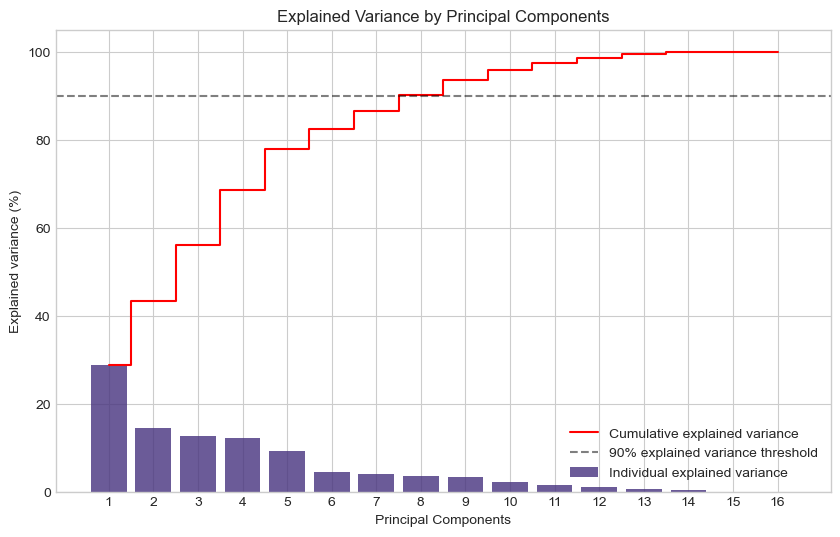

Number of components for 90% variance: 8


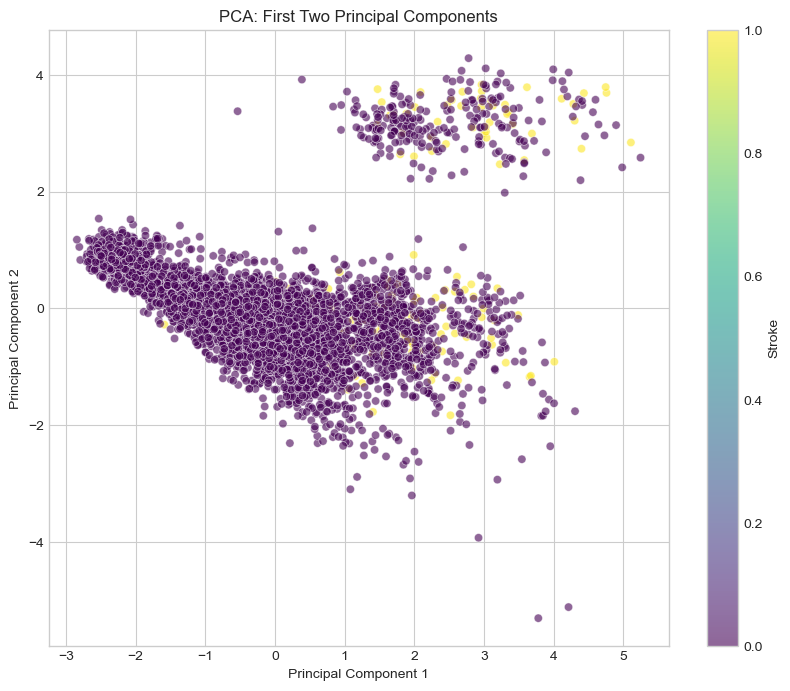

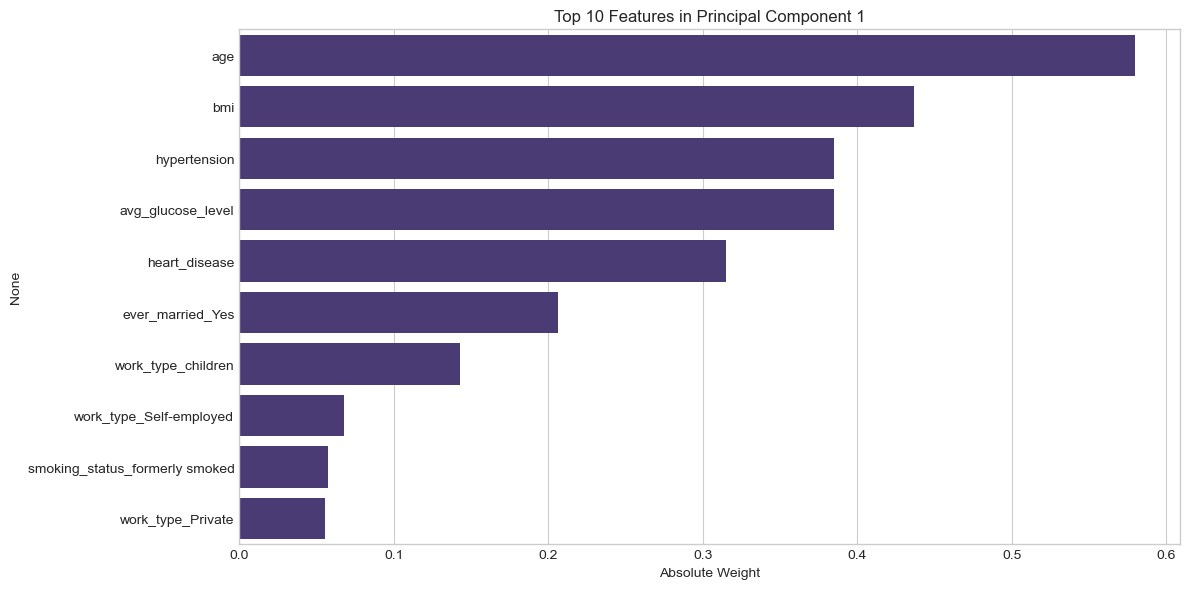

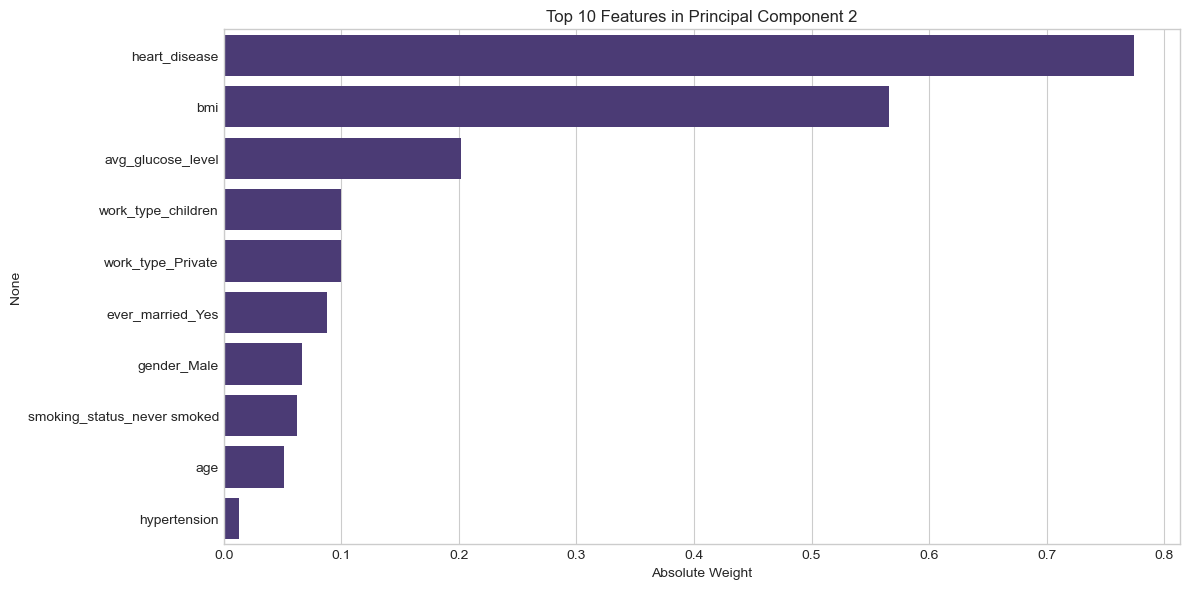

Applying t-SNE...


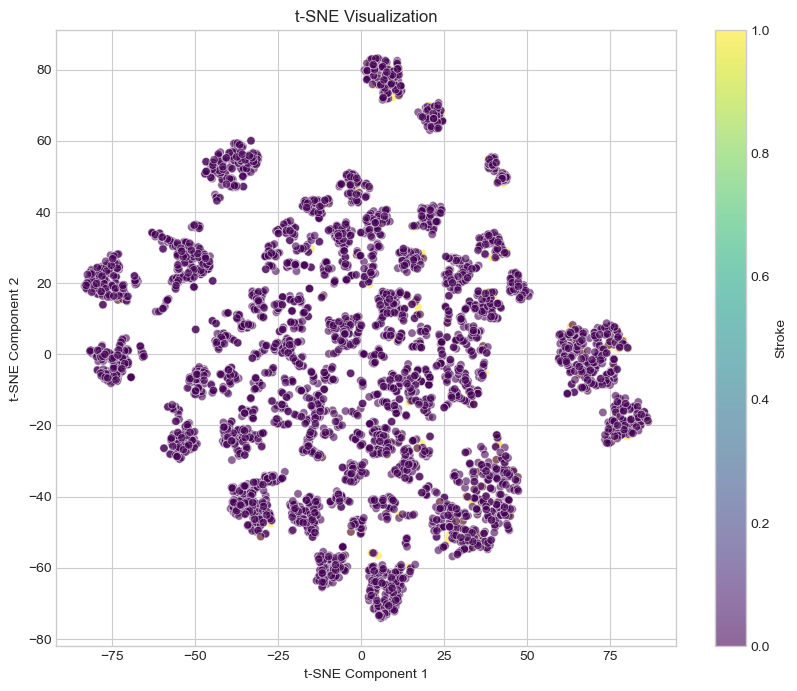

Applying UMAP...


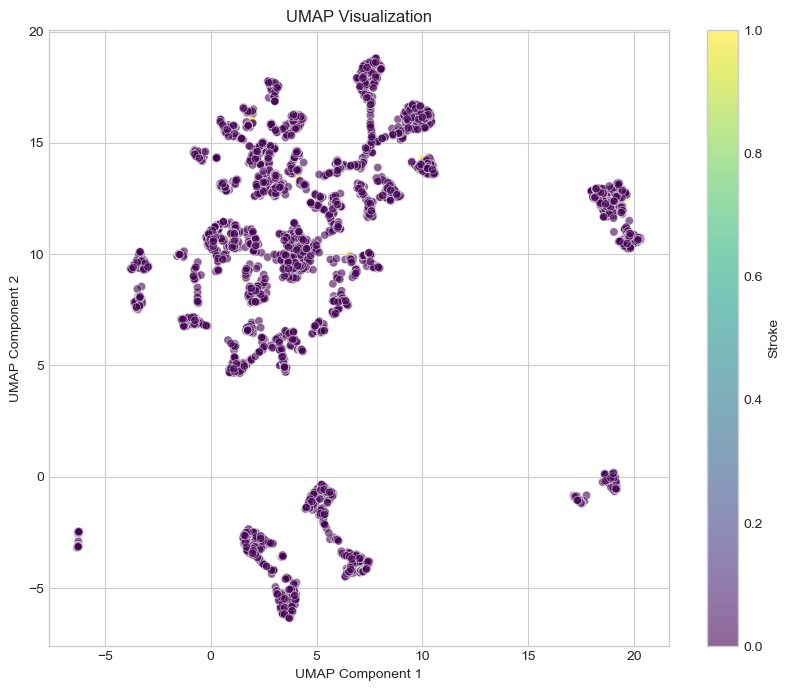

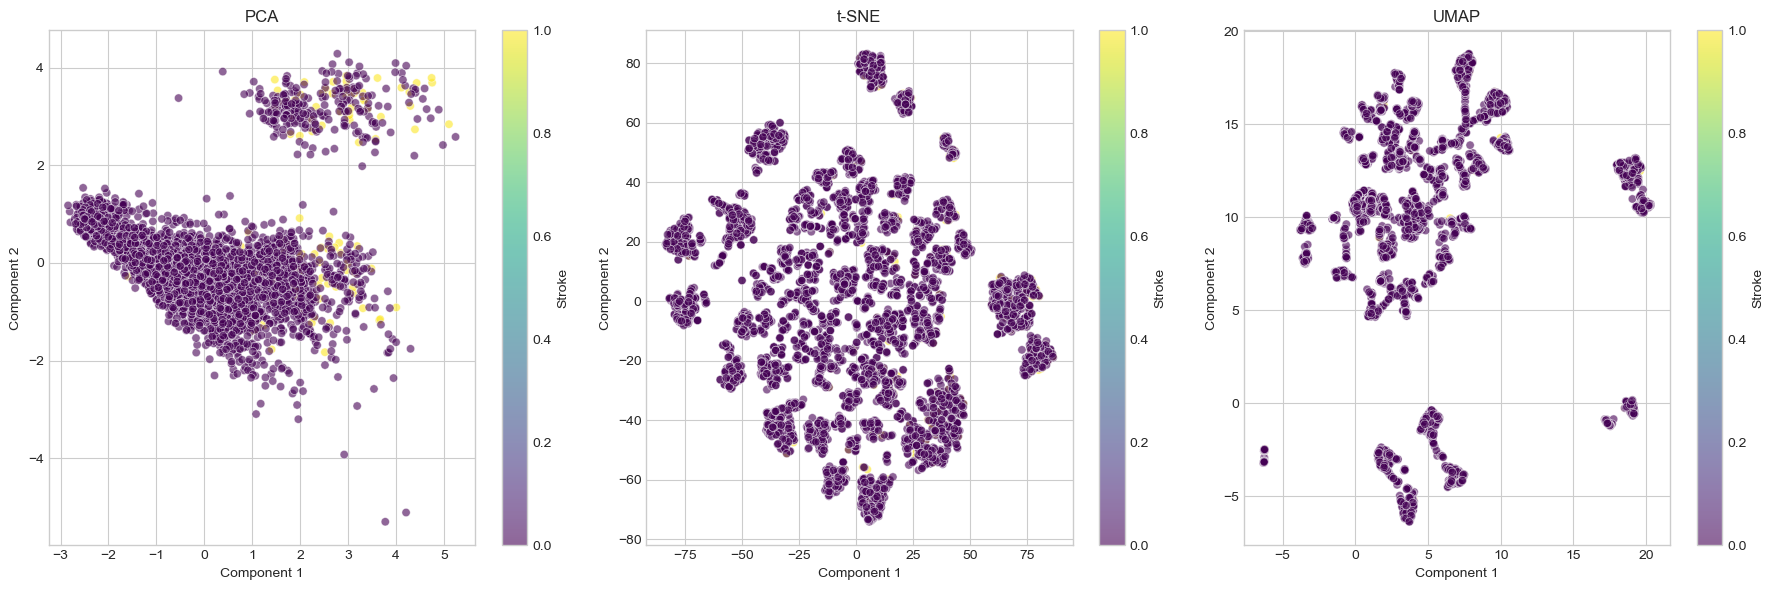


Performing clustering analysis...
Applying K-Means clustering...


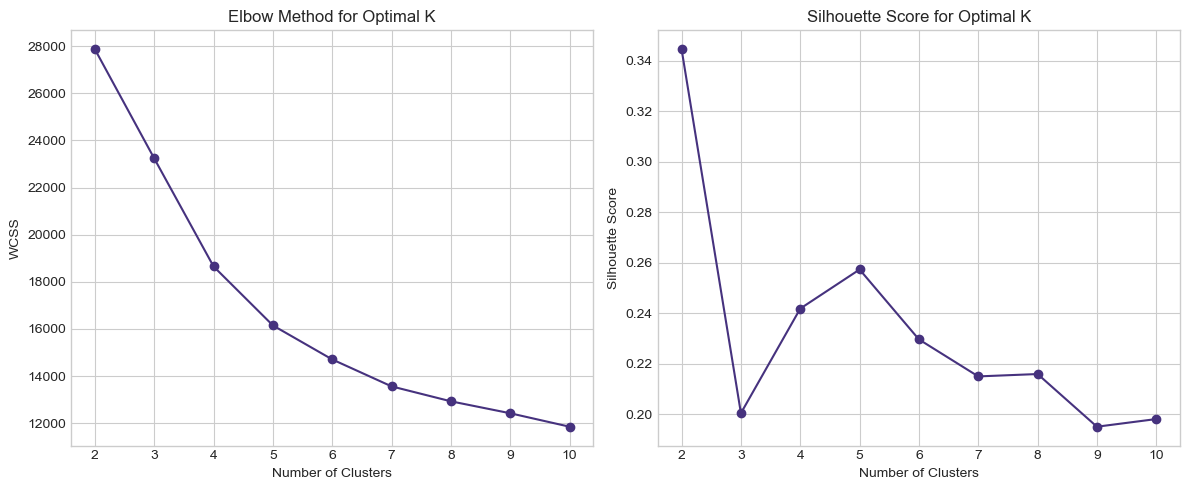

Optimal number of clusters (K-Means): 2


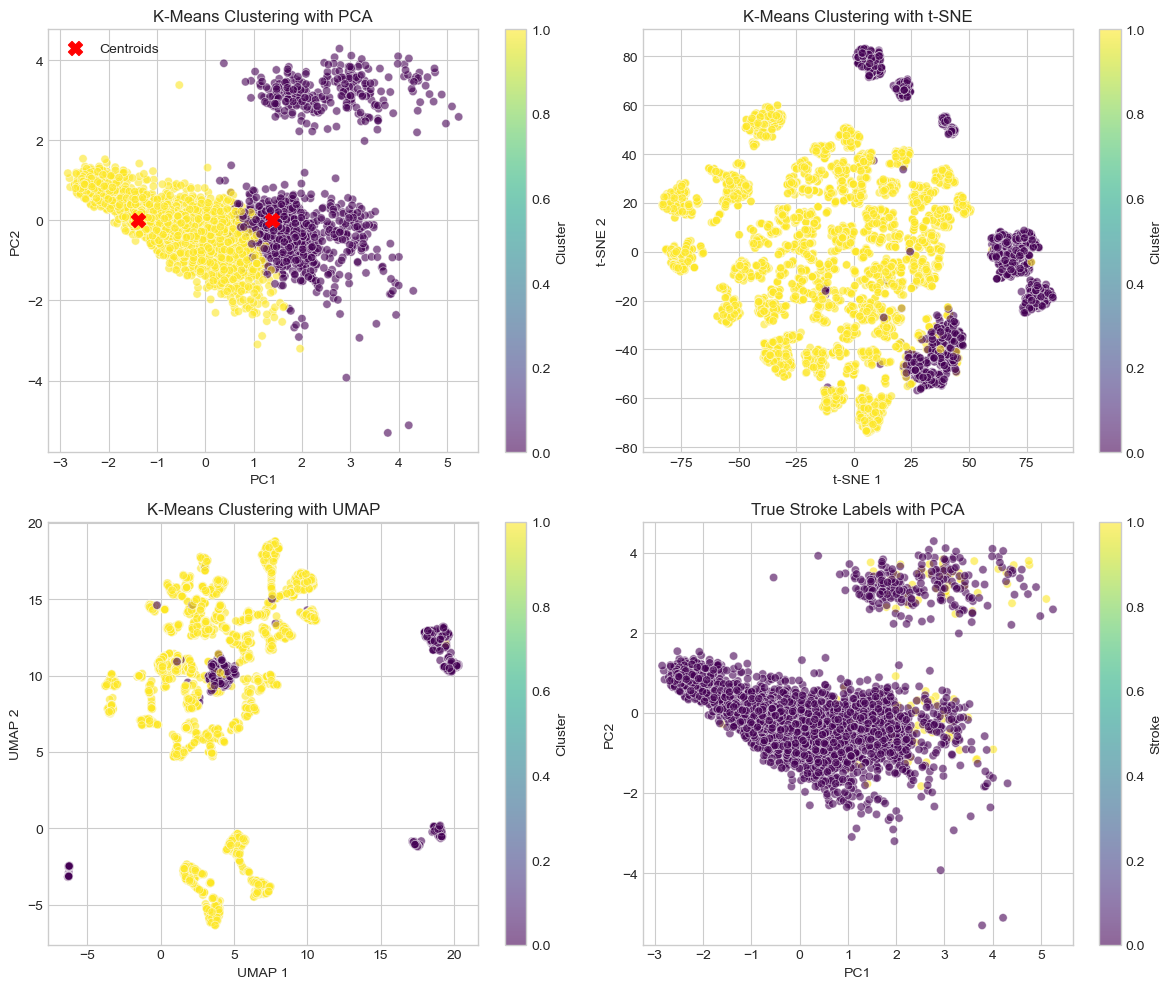


K-Means Cluster Analysis:


Stroke %    Avg Age  Hypertension %  Heart Disease %  Avg Glucose  \
cluster                                                                       
0        12.897196  63.094393       46.355140        25.700935   157.619327   
1         2.747525  37.964604        0.049505         0.024752    92.515334   

           Avg BMI  Size  Size %  
cluster                           
0        33.270674  1070    20.9  
1        27.822186  4040    79.1

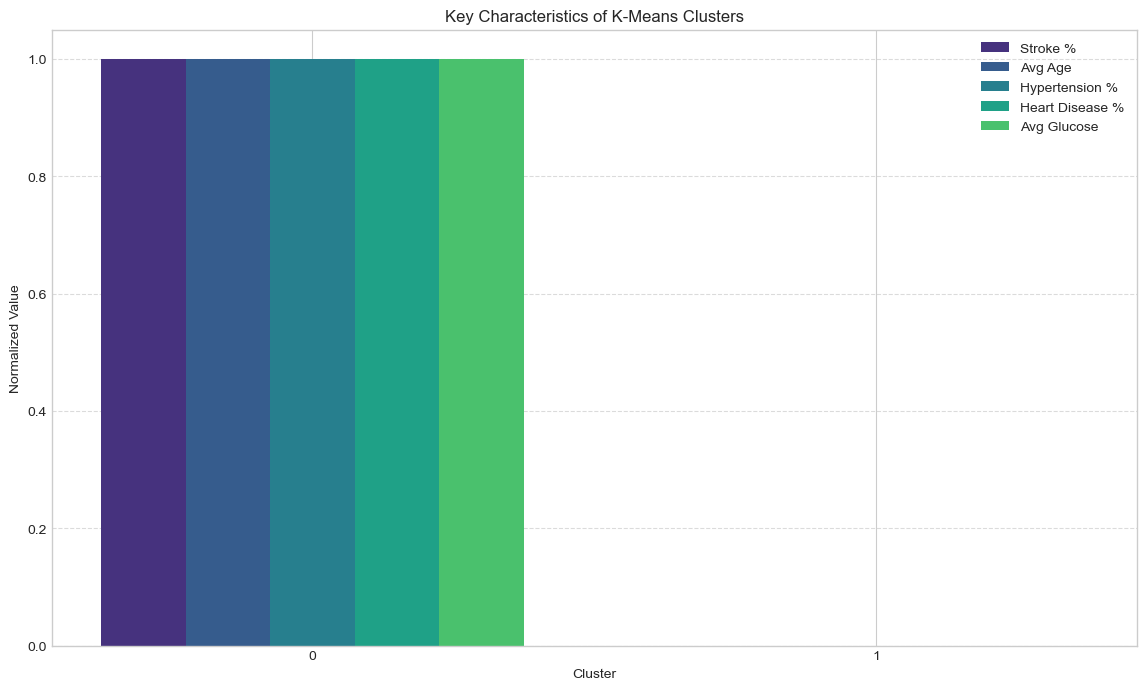

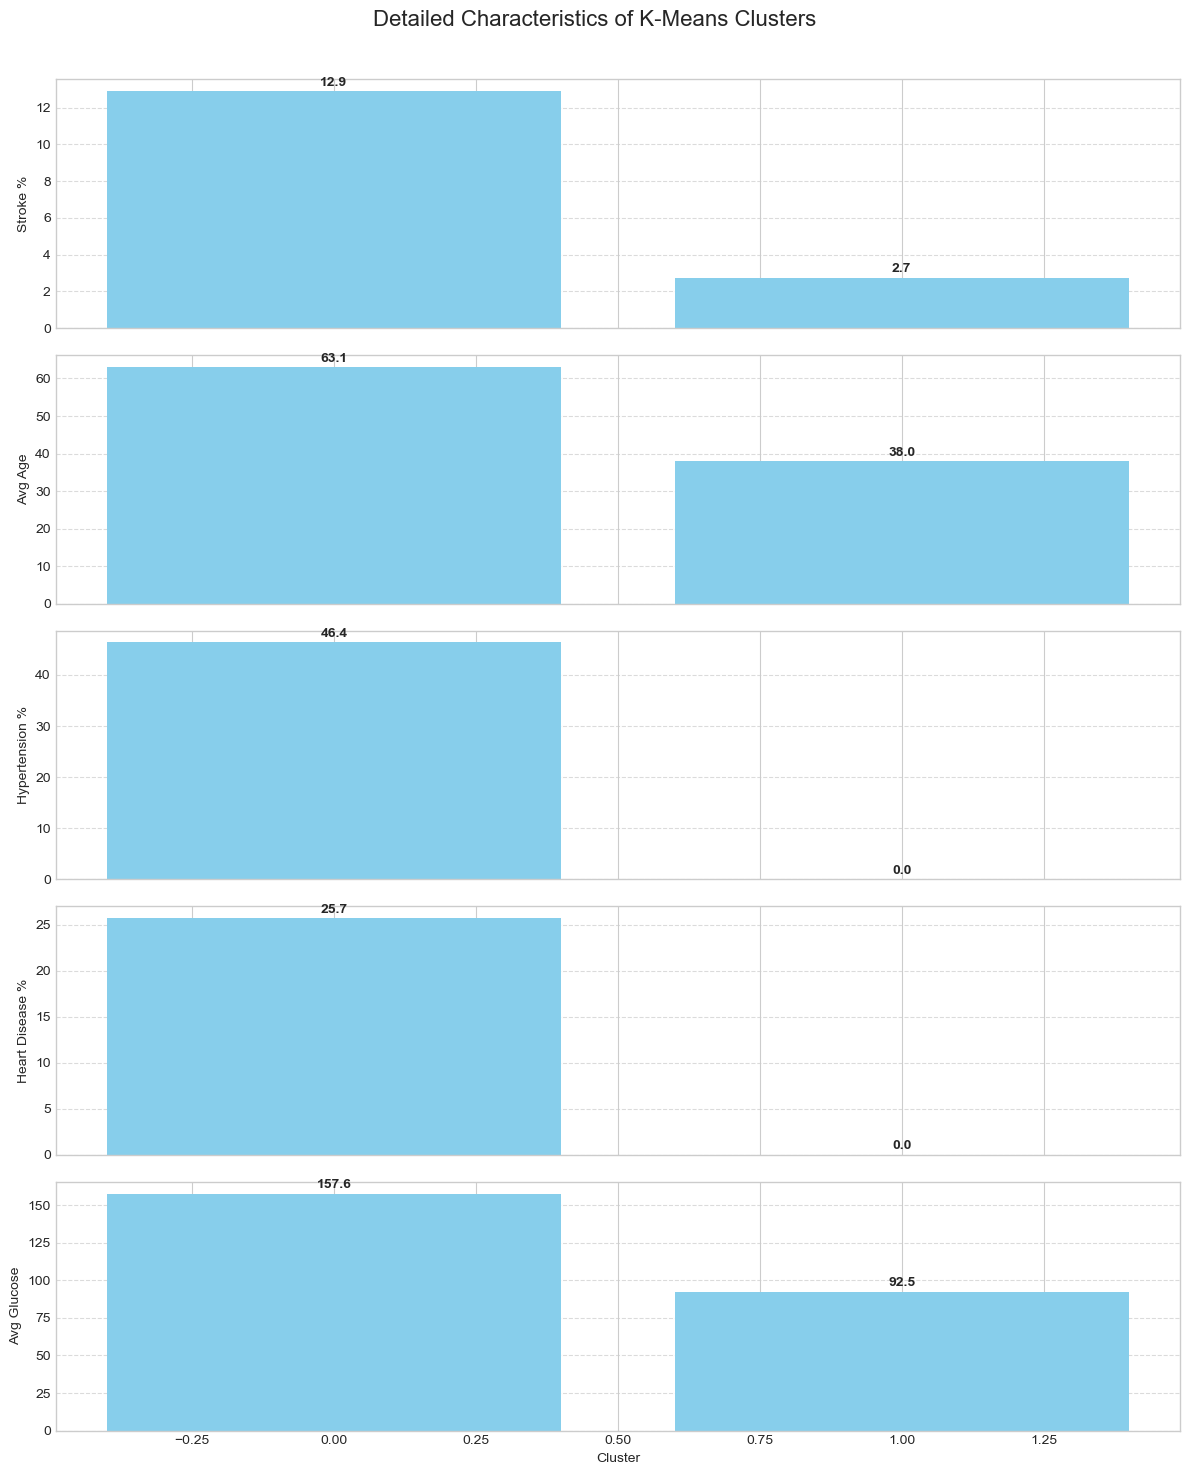

Applying Hierarchical clustering...


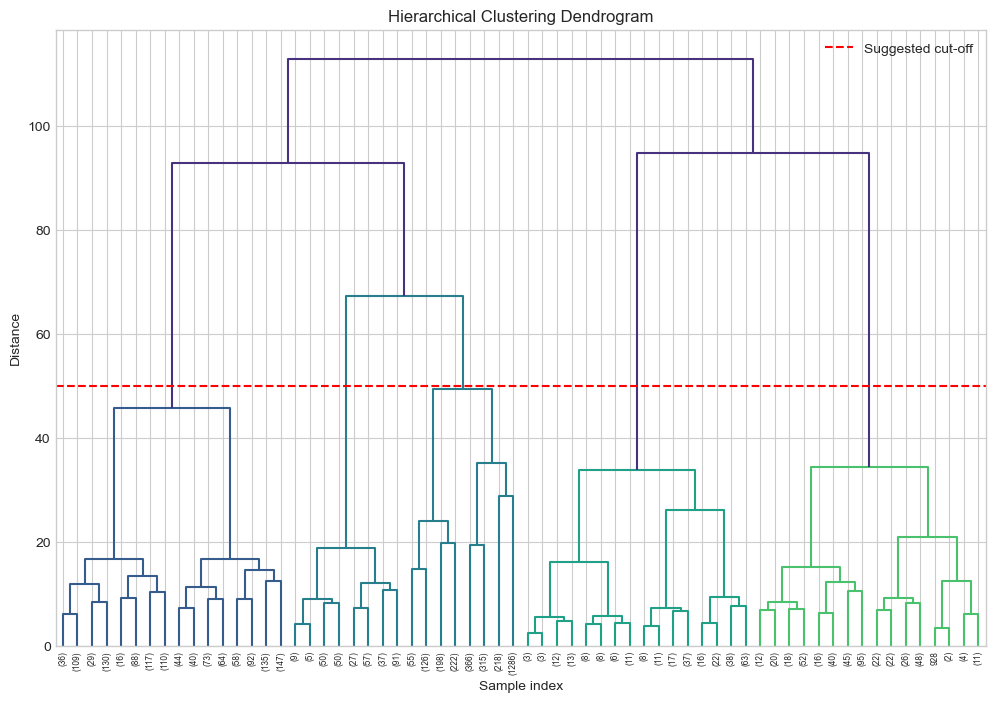

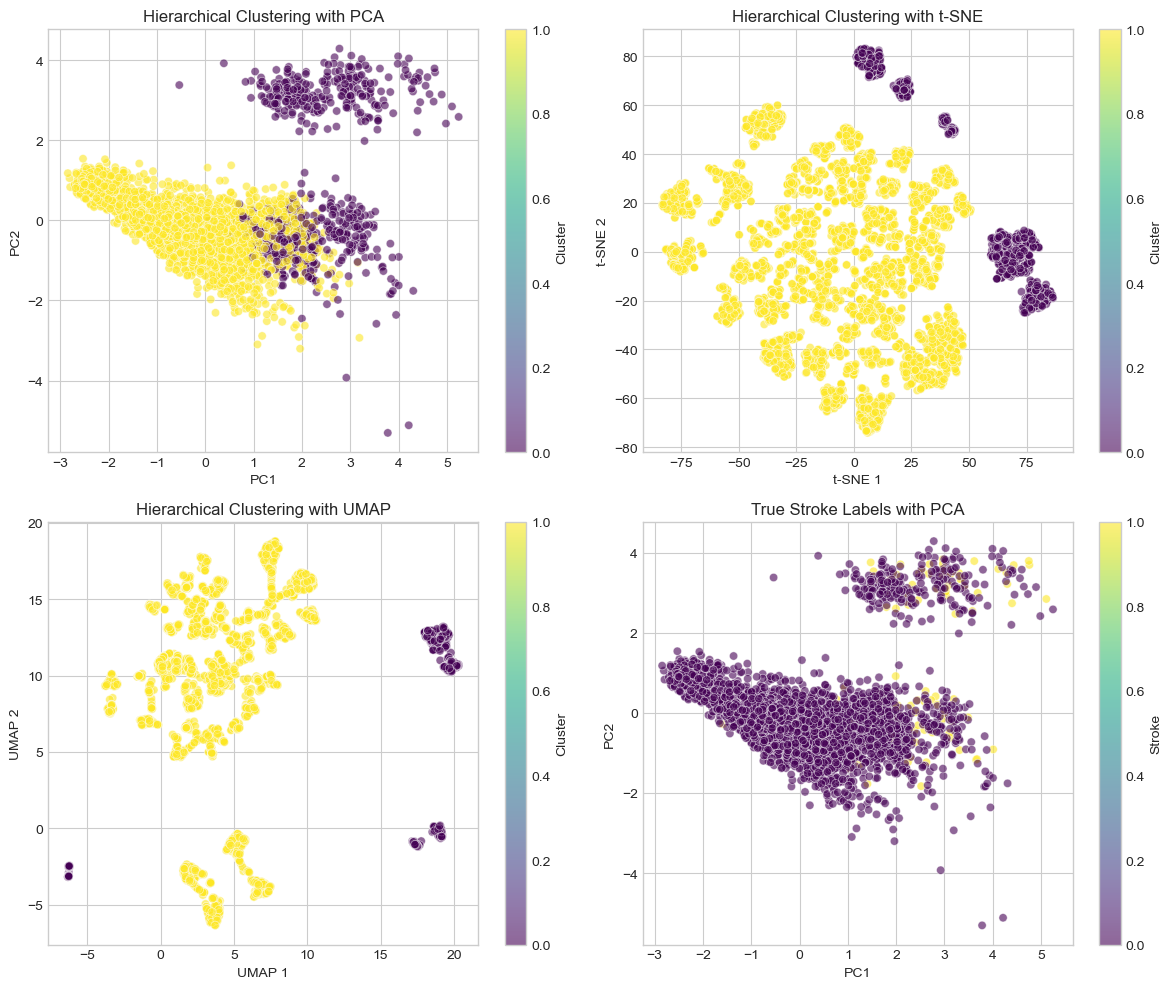


Hierarchical Clustering Analysis:


Stroke %    Avg Age  Hypertension %  Heart Disease %  Avg Glucose  \
cluster                                                                       
0        14.084507  63.804225       70.140845        38.873239   130.871620   
1         3.386364  39.906136        0.000000         0.000000   102.158132   

           Avg BMI  Size  Size %  
cluster                           
0        32.148270   710    13.9  
1        28.408753  4400    86.1

Applying DBSCAN clustering...
Using epsilon for DBSCAN: 2.0 with 4 clusters
DBSCAN found 4 clusters and 5 noise points


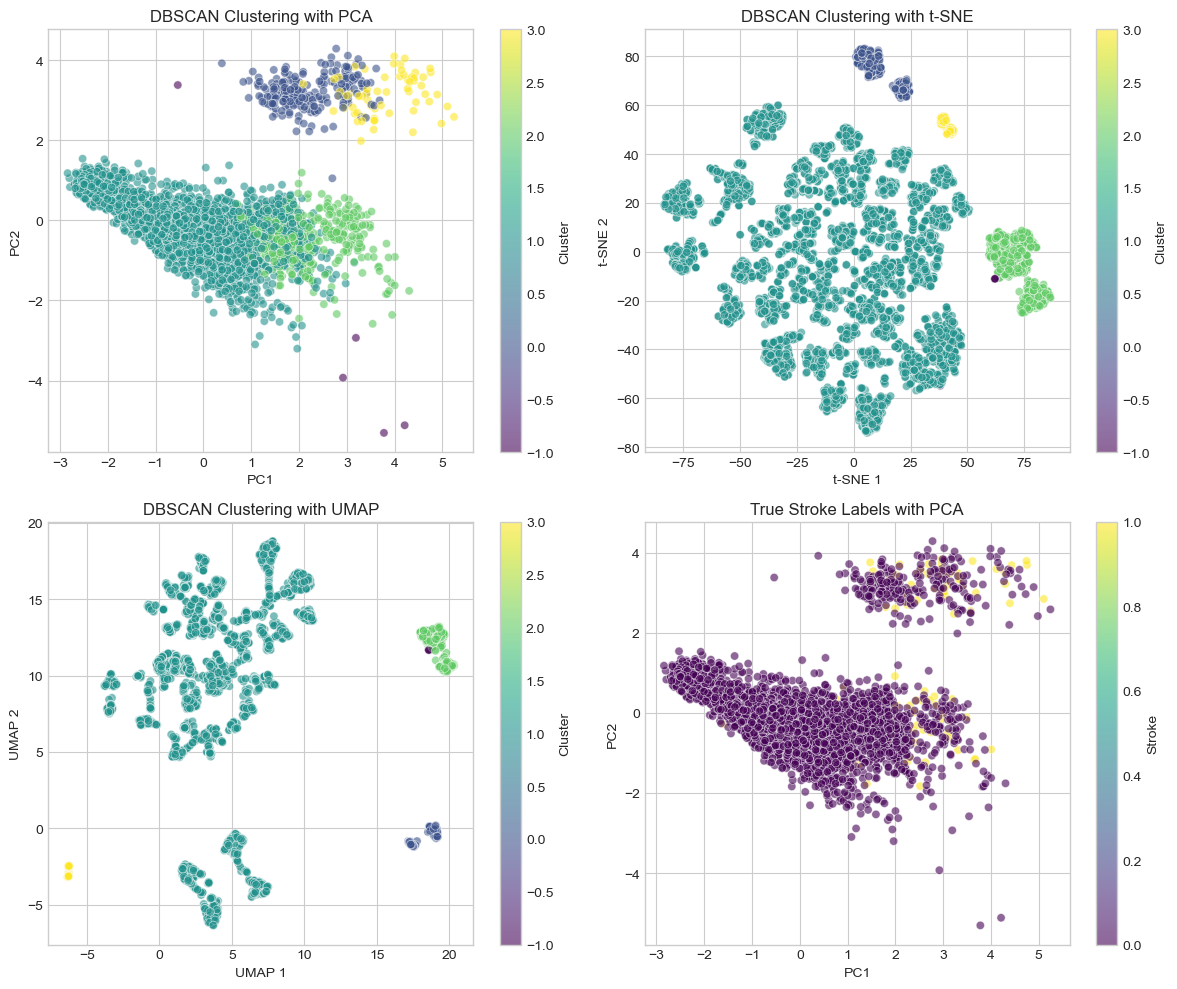


DBSCAN Cluster Analysis:


Stroke %    Avg Age  Hypertension %  Heart Disease %  Avg Glucose  \
cluster                                                                       
 3       20.312500  70.578125           100.0            100.0   151.207031   
 0       16.113744  67.777251             0.0            100.0   132.804929   
 2       12.296984  61.259861           100.0              0.0   127.536589   
 1        3.387133  39.905660             0.0              0.0   102.133508   
-1        0.000000  24.400000            60.0             20.0    92.394000   

           Avg BMI  Size  Size %  
cluster                           
 3       31.381034     5     0.1  
 0       29.985870   211     4.1  
 2       32.850769  4399    86.1  
 1       28.398572   431     8.4  
-1       73.780000    64     1.3


Agreement between K-Means and Hierarchical Clustering: 92.84%

Performing anomaly detection...
Applying Isolation Forest...


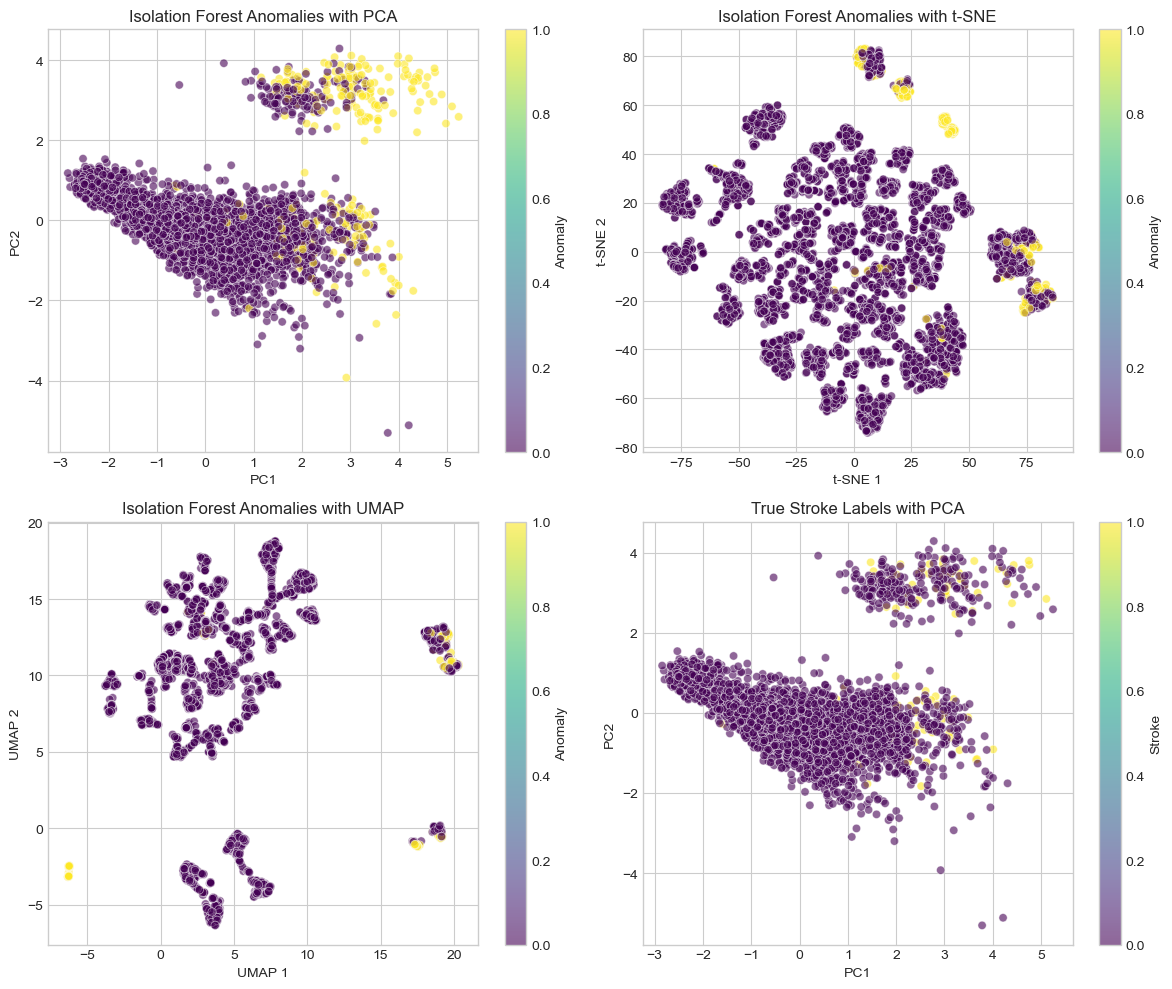


Isolation Forest Anomaly Analysis:


Stroke %    Avg Age  Hypertension %  Heart Disease %  \
is_anomaly                                                          
0            4.264524  41.973630        7.107540         2.698805   
1           16.406250  66.984375       59.765625        56.640625   

            Avg Glucose    Avg BMI  Size  Size %  
is_anomaly                                        
0            103.528576  28.693755  4854    95.0  
1            155.808281  32.896567   256     5.0

Stroke rate in anomalies: 16.41%
Stroke rate in normal points: 4.26%
Applying Local Outlier Factor...


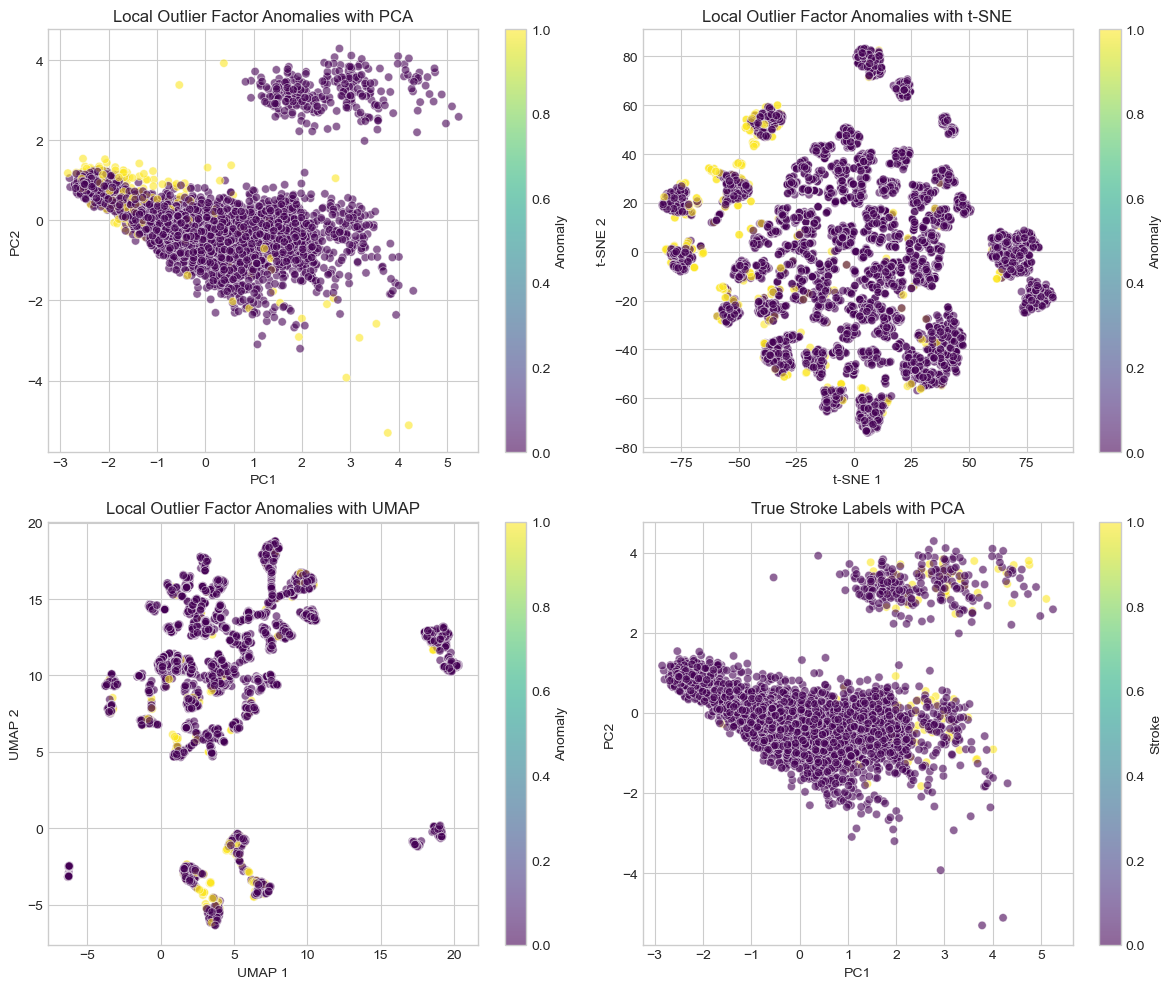


Local Outlier Factor Anomaly Analysis:


Stroke %    Avg Age  Hypertension %  Heart Disease %  Avg Glucose  \
is_anomaly                                                                      
0           5.026782  44.237478       10.115369         5.624227   105.987073   
1           1.953125  24.059687        2.734375         1.171875   109.192891   

              Avg BMI  Size  Size %  
is_anomaly                           
0           29.082911  4854    95.0  
1           25.373307   256     5.0

Stroke rate in LOF anomalies: 1.95%
Stroke rate in LOF normal points: 5.03%
Agreement between Isolation Forest and LOF: 90.25%

Performing association rule mining...
Encoded data shape: (5110, 30)
Number of binary features: 30
Stroke group size: 249
Non-stroke group size: 4861

Found 179 association rules for stroke group
Top 5 rules by lift for stroke group:


antecedents  \
111               (bmi_group_Normal, ever_married_Yes)   
24                                  (bmi_group_Normal)   
132  (Residence_type_Urban, ever_married_Yes, smoki...   
166          (age_group_55-70, glucose_group_Diabetic)   
48   (Residence_type_Urban, smoking_status_never sm...   

                               consequents   support  confidence      lift  
111                        (age_group_>70)  0.100402    0.806452  1.568800  
24                         (age_group_>70)  0.116466    0.783784  1.524704  
132                        (gender_Female)  0.112450    0.800000  1.412766  
166  (ever_married_Yes, work_type_Private)  0.112450    0.756757  1.395796  
48                         (gender_Female)  0.144578    0.782609  1.382054

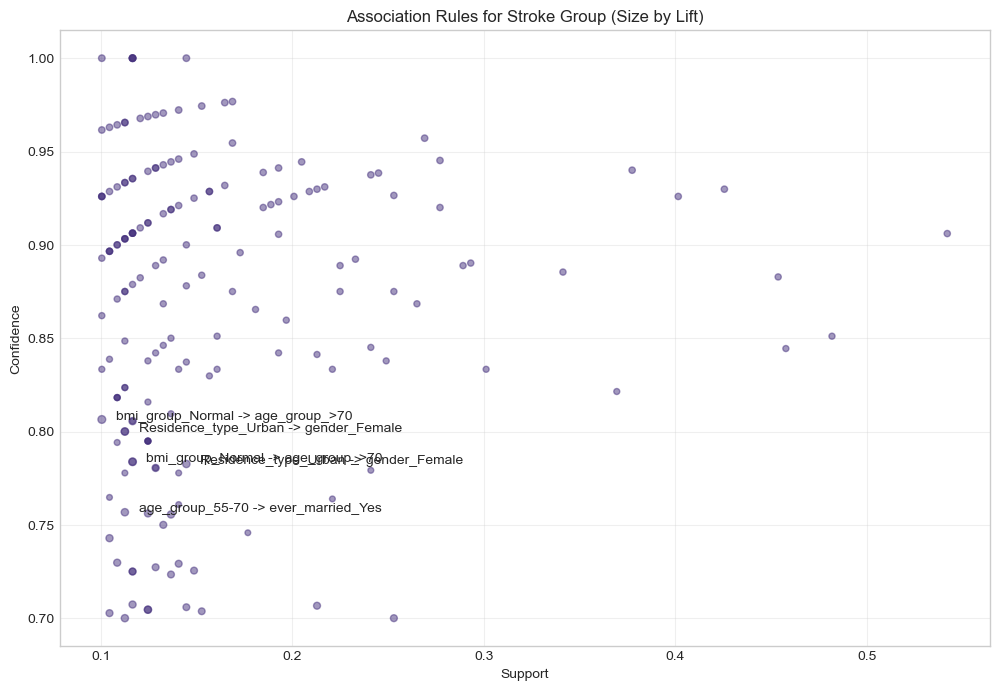


Found 79 association rules for non-stroke group
Top 5 rules by lift for non-stroke group:


antecedents  \
68  (ever_married_No, age_group_<40, smoking_statu...   
73                               (work_type_children)   
28                               (work_type_children)   
71                (work_type_children, age_group_<40)   
62                               (work_type_children)   

                                          consequents   support  confidence  \
68                               (work_type_children)  0.126723    0.725559   
73  (ever_married_No, age_group_<40, smoking_statu...  0.126723    0.899270   
28          (ever_married_No, smoking_status_Unknown)  0.126723    0.899270   
71          (ever_married_No, smoking_status_Unknown)  0.126723    0.899270   
62            (age_group_<40, smoking_status_Unknown)  0.126723    0.899270   

        lift  
68  5.148824  
73  5.148824  
28  4.895131  
71  4.895131  
62  4.393318

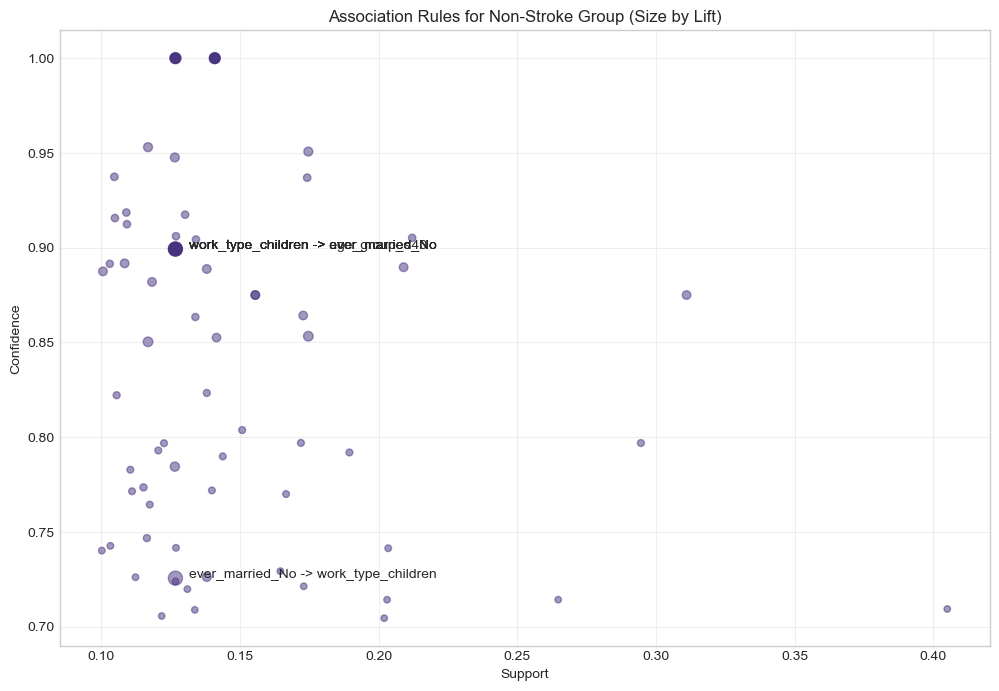


Found 81 association rules for the entire dataset
Top 5 rules by lift for the entire dataset:


antecedents  \
75                               (work_type_children)   
70  (ever_married_No, age_group_<40, smoking_statu...   
73                (work_type_children, age_group_<40)   
29                               (work_type_children)   
63                               (work_type_children)   

                                          consequents   support  confidence  \
75  (ever_married_No, age_group_<40, smoking_statu...  0.120939    0.899563   
70                               (work_type_children)  0.120939    0.726204   
73          (ever_married_No, smoking_status_Unknown)  0.120939    0.899563   
29          (ever_married_No, smoking_status_Unknown)  0.120939    0.899563   
63            (age_group_<40, smoking_status_Unknown)  0.120939    0.899563   

        lift  
75  5.401608  
70  5.401608  
73  5.101852  
29  5.101852  
63  4.610600

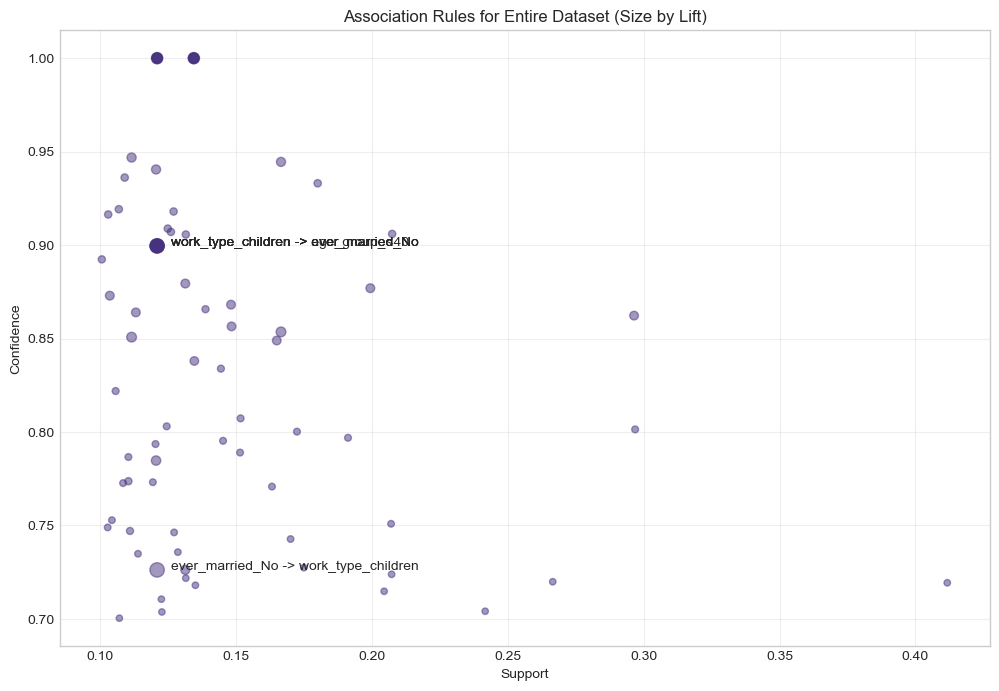


Analyzing high-risk clusters and anomalies...
Highest risk cluster: 0 with stroke rate: 12.90%

High Risk Cluster vs Overall Population:


High Risk Cluster  Overall Population  Difference (%)
age                        63.094393           43.226614            46.0
hypertension               46.355140            9.745597           375.7
heart_disease              25.700935            5.401174           375.8
avg_glucose_level         157.619327          106.147677            48.5
bmi                        33.270674           28.893237            15.2

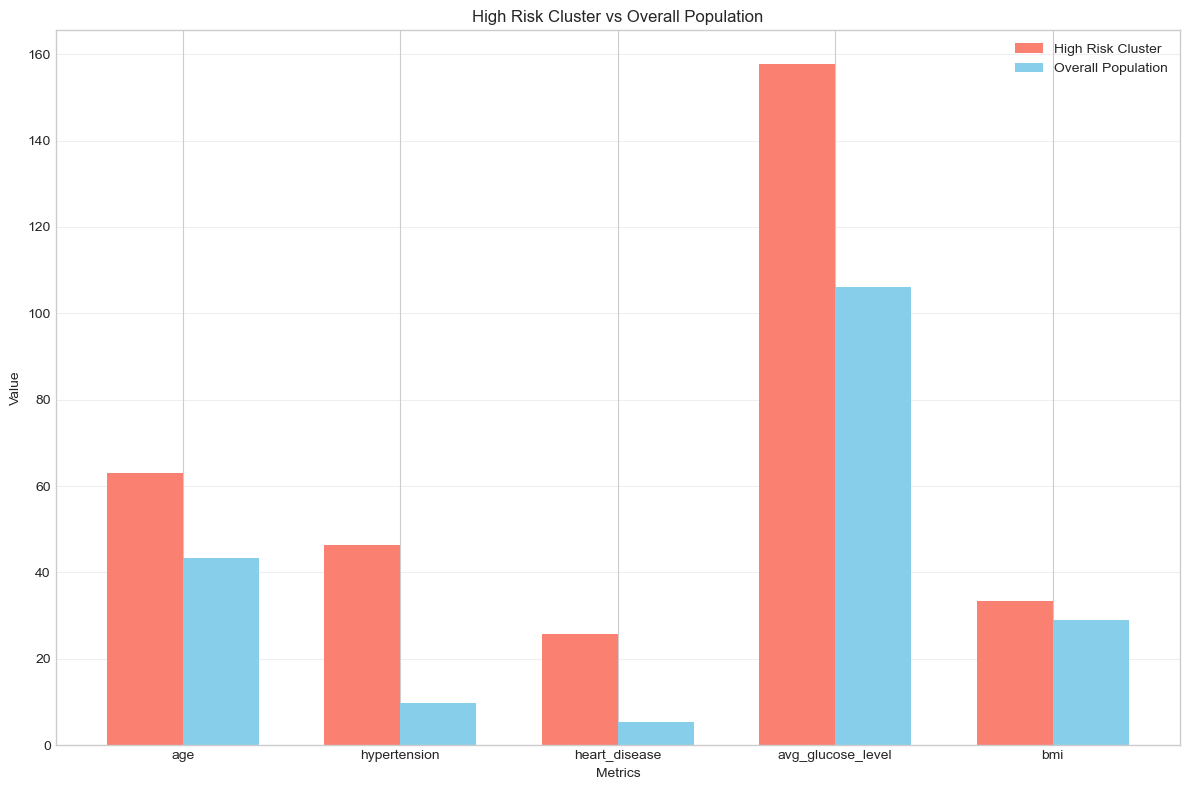


Categorical Variables Distribution:

gender:


High Risk Cluster (%)  Overall Population (%)  Difference (p.p.)
gender                                                                  
Female              51.682243               58.590998          -6.908755
Male                48.317757               41.389432           6.928325
Other                     NaN                0.019569                NaN


ever_married:


High Risk Cluster (%)  Overall Population (%)  Difference (p.p.)
ever_married                                                                  
Yes                       90.934579               65.616438          25.318141
No                         9.065421               34.383562         -25.318141


work_type:


High Risk Cluster (%)  Overall Population (%)  \
work_type                                                      
Govt_job                   14.953271               12.857143   
Never_worked                     NaN                0.430528   
Private                    57.850467               57.240705   
Self-employed              27.196262               16.027397   
children                         NaN               13.444227   

               Difference (p.p.)  
work_type                         
Govt_job                2.096128  
Never_worked                 NaN  
Private                 0.609763  
Self-employed          11.168864  
children                     NaN


Residence_type:


High Risk Cluster (%)  Overall Population (%)  \
Residence_type                                                  
Urban                       50.560748               50.802348   
Rural                       49.439252               49.197652   

                Difference (p.p.)  
Residence_type                     
Urban                   -0.241601  
Rural                    0.241601


smoking_status:


High Risk Cluster (%)  Overall Population (%)  \
smoking_status                                                   
Unknown                      14.392523               30.215264   
formerly smoked              25.607477               17.318982   
never smoked                 41.308411               37.025440   
smokes                       18.691589               15.440313   

                 Difference (p.p.)  
smoking_status                      
Unknown                 -15.822741  
formerly smoked           8.288494  
never smoked              4.282971  
smokes                    3.251276

<Figure size 1200x600 with 0 Axes>

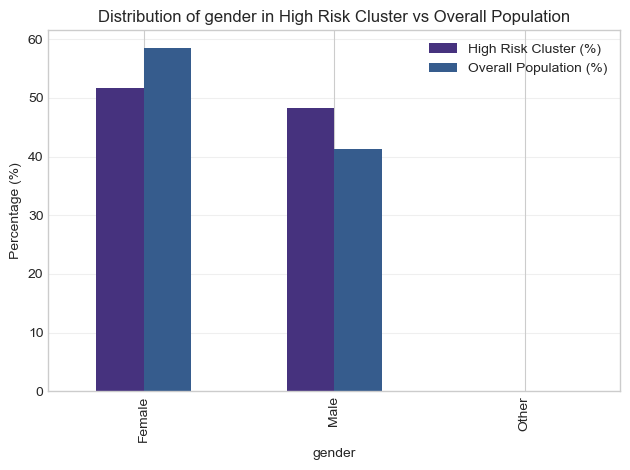

<Figure size 1200x600 with 0 Axes>

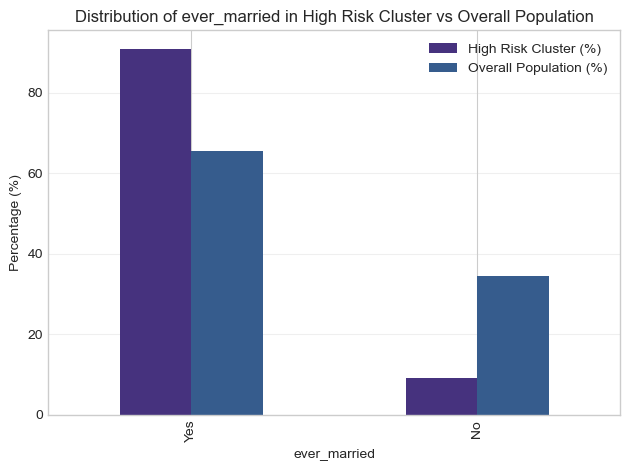

<Figure size 1200x600 with 0 Axes>

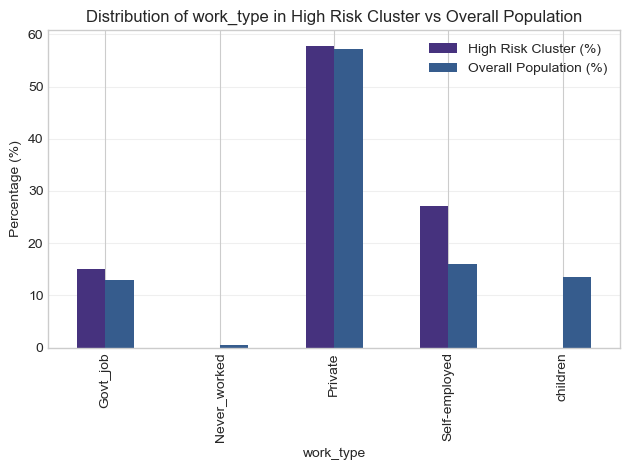

<Figure size 1200x600 with 0 Axes>

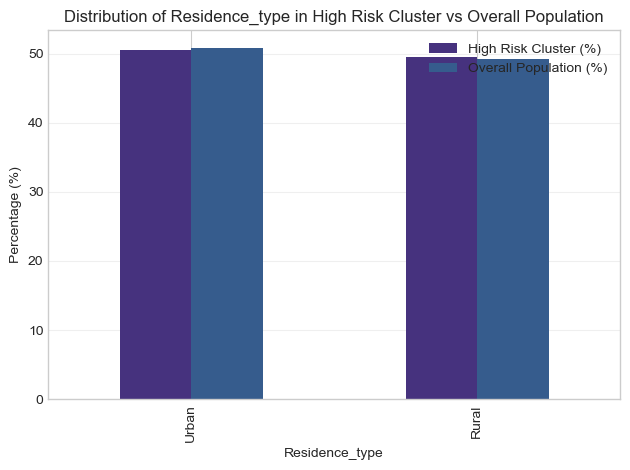

<Figure size 1200x600 with 0 Axes>

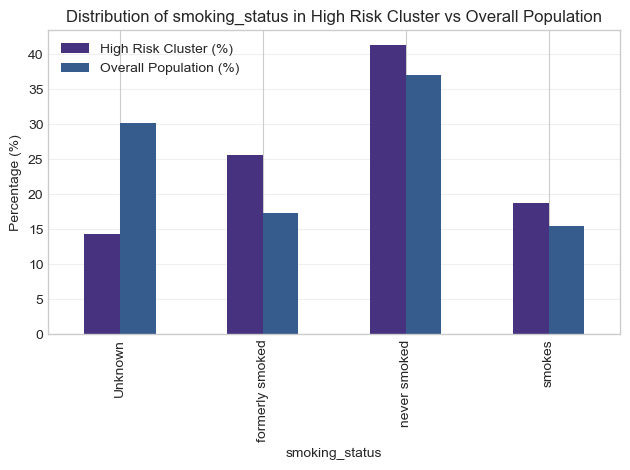


Stroke rate in high-risk profile: 12.72%
Stroke rate in normal-risk profile: 2.76%
Risk ratio: 4.61x


<Figure size 1200x600 with 0 Axes>

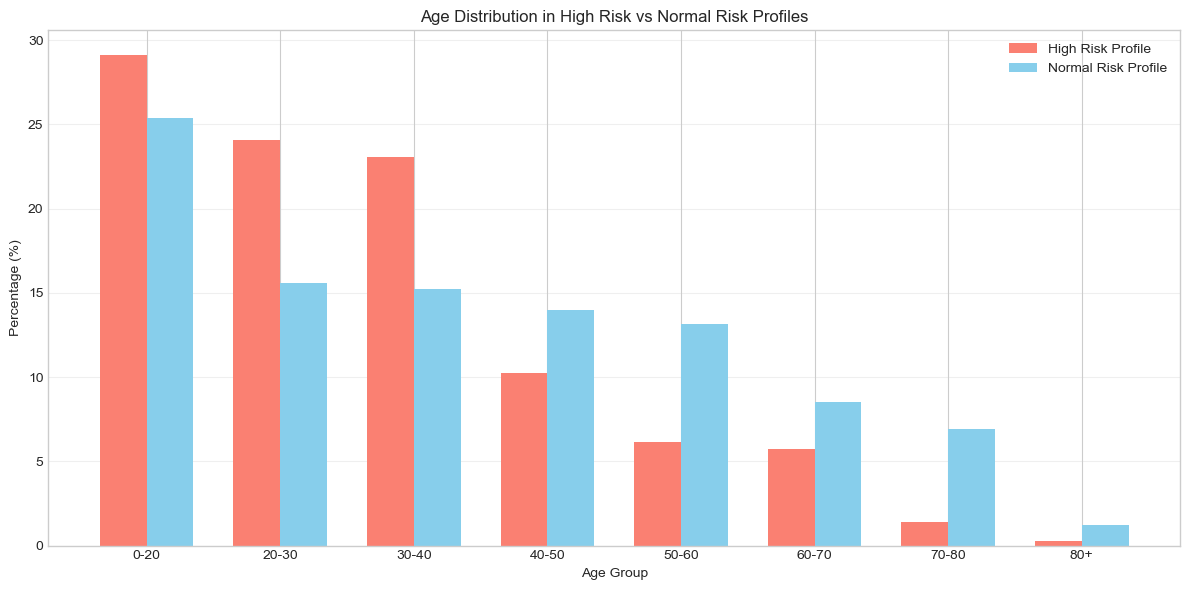


High Risk Profile Summary:


Metric        Value
0  Percentage of Population       21.23%
1               Stroke Rate       12.72%
2                Risk Ratio        4.61x
3               Average Age   62.8 years
4            Hypertension %        45.8%
5           Heart Disease %        25.3%
6           Average Glucose  157.0 mg/dL


Creating summary report...
UNSUPERVISED LEARNING ANALYSIS - STROKE PREDICTION

1. DIMENSIONALITY REDUCTION

Principal Component Analysis (PCA):
- First component explains 28.83% of variance
- Second component explains 14.65% of variance
- Top two components together explain 43.48% of variance
- Number of components needed for 90% variance: 8

Key insights from dimensionality reduction:
- Data shows natural clustering that partially aligns with stroke cases
- Stroke cases tend to cluster differently from non-stroke cases
- t-SNE and UMAP reveal more complex patterns than linear PCA

2. CLUSTERING ANALYSIS

K-Means Clustering:
- Optimal number of clusters: 2
- Highest risk cluster: 0 with stroke rate of 12.90%
- Overall dataset stroke rate: 4.87%
- Risk ratio for highest risk cluster: 2.65x

High Risk Cluster Characteristics:
- Average age: 63.1 years
- Hypertension: 46.4%
- Heart disease: 25.7%
- Average glucose level: 157.6 mg/dL
- Percentage of population: 20.9%

3. ANOMALY DETECTION

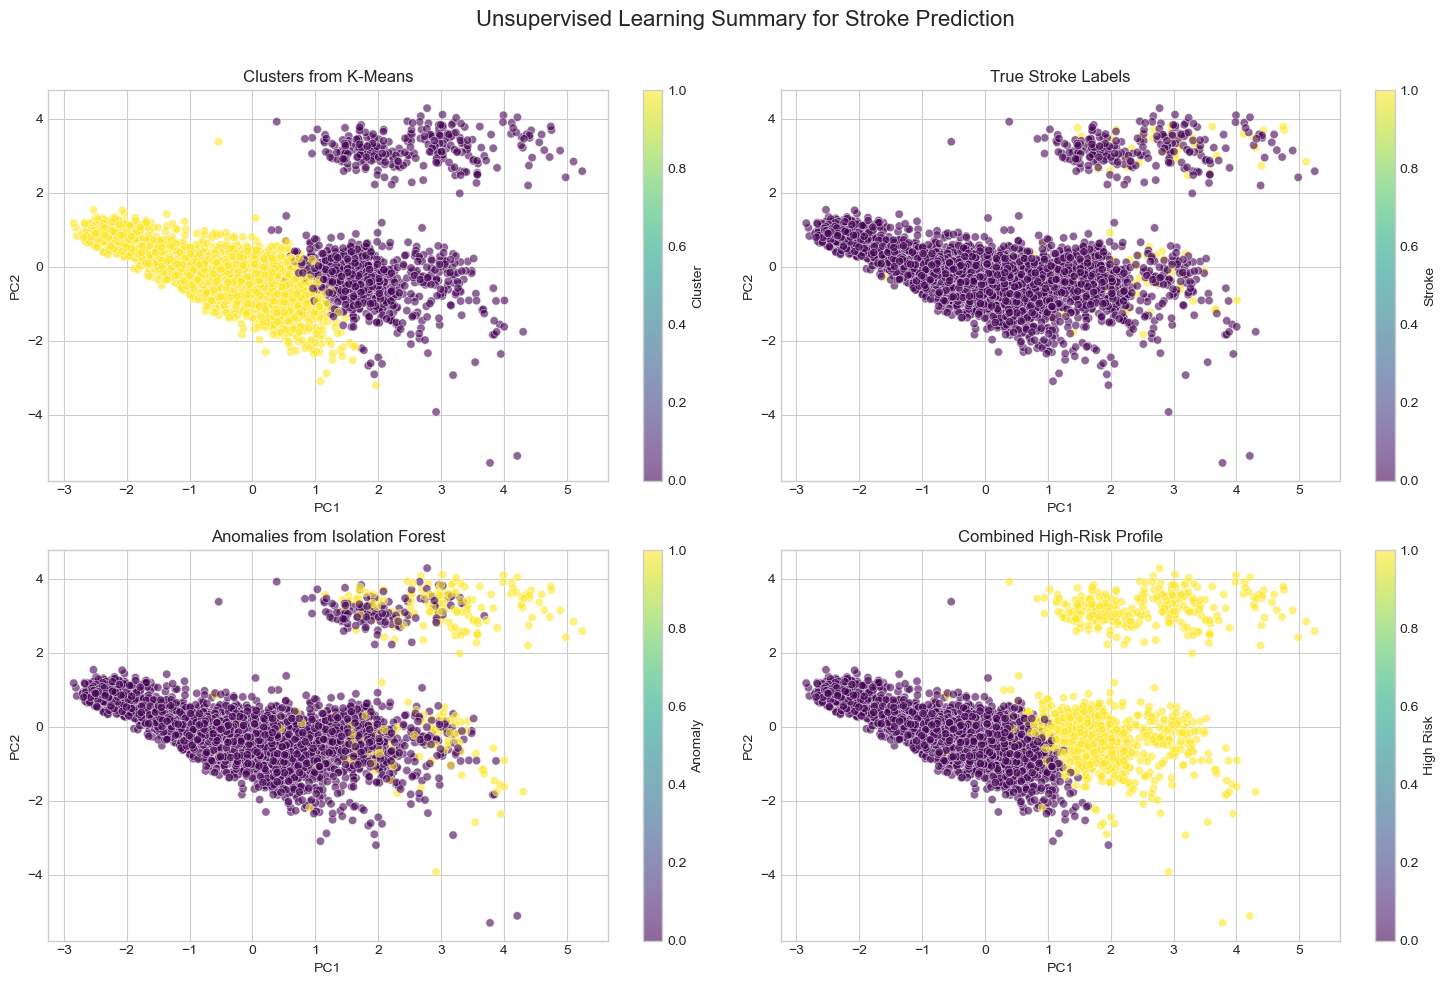


Unsupervised learning analysis completed successfully!


In [18]:
def main():
    """
    Main function to run the entire unsupervised learning pipeline
    """
    print("Starting unsupervised learning analysis for stroke prediction...")
    
    # Load and preprocess data
    df, X_scaled, X_encoded, feature_names = load_and_preprocess_data('C://Users//Nikhil//Desktop/Stroke Prediction//healthcare-dataset-stroke-data.csv')
    
    # Perform dimensionality reduction
    pca_data, tsne_data, umap_data, pca_model = perform_dimensionality_reduction(X_scaled, df, feature_names)
    
    # Perform clustering analysis
    df_kmeans, df_hc, df_dbscan, optimal_k = perform_clustering_analysis(
        X_scaled, df, X_encoded, pca_data, tsne_data, umap_data)
    
    # Perform anomaly detection
    df_iso, df_lof = perform_anomaly_detection(X_scaled, df, pca_data, tsne_data, umap_data)
    
    # Perform association rule mining
    perform_association_rule_mining(df)
    
    # Analyze high-risk clusters and anomalies
    high_risk_summary = analyze_high_risk_clusters(df_kmeans, df_iso, optimal_k)
    
    # Create summary report
    create_summary_report(df, df_kmeans, df_iso, pca_model, high_risk_summary)
    
    print("\nUnsupervised learning analysis completed successfully!")

# Call the main function if the script is run directly
if __name__ == "__main__":
    main()